In [1]:
# Cargar Librerias Generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

from scipy.stats import skew

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, roc_curve, auc, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

from prettytable import PrettyTable
import time
from datetime import datetime

tf.random.set_seed(42)

# Carga de datos

In [2]:
# Cargar lista de insumos
dir = 'raw_data/'
file = 'files_list.csv'

file_df = pd.read_csv(dir + file, index_col='ind')

#Separar códigos bursátiles
pattern = r'\((.*?)\)'

file_df['stock'] = file_df['name'].str.extract(pattern)
file_df['name'] = file_df['name'].str.replace(pattern, '')

# Seleccionar el top de empresas a usar (siempre cargar negativos y 0)
top_n = 30

file_df = file_df[file_df.index < top_n + 1]
file_df

C:\Users\Carlos\AppData\Local\Temp\ipykernel_24936\2252273142.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  file_df['name'] = file_df['name'].str.replace(pattern, '')


name     stock
ind                                            
-2                          FEDFUNDS   FEDFUNDS
-1                            UNRATE     UNRATE
 0                        NASDAQ 100       ^NDX
 1                        Apple Inc.       AAPL
 2             Microsoft Corporation       MSFT
 3                  Amazon.com, Inc.       AMZN
 4                NVIDIA Corporation       NVDA
 5              Meta Platforms, Inc.       META
 6                     Broadcom Inc.       AVGO
 7                       Tesla, Inc.       TSLA
 8                     Alphabet Inc.       GOOG
 9                     Alphabet Inc.      GOOGL
 10                       Adobe Inc.       ADBE
 11                    PepsiCo, Inc.        PEP
 12     Costco Wholesale Corporation       COST
 13              Cisco Systems, Inc.       CSCO
 14              Comcast Corporation      CMCSA
 15                    Netflix, Inc.       NFLX
 16     Advanced Micro Devices, Inc.        AMD
 17                T-Mobile US, Inc.       TMUS
 18   Texas Instruments Incorporated        TXN
 19                      Intuit Inc.       INTU
 20                Intel Corporation       INTC
 21                       Amgen Inc.       AMGN
 22          Applied Materials, Inc.       AMAT
 23            QUALCOMM Incorporated       QCOM
 24     Honeywell International Inc.        HON
 25            Booking Holdings Inc.       BKNG
 26            Starbucks Corporation       SBUX
 27         Intuitive Surgical, Inc.       ISRG
 28  Automatic Data Processing, Inc.        ADP
 29     Mondelez International, Inc.       MDLZ
 30            Gilead Sciences, Inc.       GILD

In [3]:
# Cargar archivos en dataframe y gardarlos en diccionario
stocks_dict = {}

for f in file_df['stock']:
    file = f + '.csv'
    df_name = f + '_DF'
    df = pd.read_csv(dir + file)
    stocks_dict[df_name] = df

stocks_dict.keys()

dict_keys(['FEDFUNDS_DF', 'UNRATE_DF', '^NDX_DF', 'AAPL_DF', 'MSFT_DF', 'AMZN_DF', 'NVDA_DF', 'META_DF', 'AVGO_DF', 'TSLA_DF', 'GOOG_DF', 'GOOGL_DF', 'ADBE_DF', 'PEP_DF', 'COST_DF', 'CSCO_DF', 'CMCSA_DF', 'NFLX_DF', 'AMD_DF', 'TMUS_DF', 'TXN_DF', 'INTU_DF', 'INTC_DF', 'AMGN_DF', 'AMAT_DF', 'QCOM_DF', 'HON_DF', 'BKNG_DF', 'SBUX_DF', 'ISRG_DF', 'ADP_DF', 'MDLZ_DF', 'GILD_DF'])

# Preprocesado de datos

In [4]:
# Parsear formato de fechas para FEDFUNDS y UNRATE
macros = ['FEDFUNDS_DF', 'UNRATE_DF']
stocks = [key for key in stocks_dict.keys() if key not in macros]

for i in macros:
    stocks_dict[i]['DATE'] = pd.to_datetime(stocks_dict[i]['DATE'], format='%d/%m/%Y')
    stocks_dict[i]['DATE'] = stocks_dict[i]['DATE'].dt.strftime('%Y-%m-%d')

    # Cambiar nombre de columna a Date
    stocks_dict[i].rename(columns= {'DATE' : 'Date'}, inplace= True)

In [5]:
# Visualización de los dataframe
stocks_dict['FEDFUNDS_DF']

Date  FEDFUNDS
0    1954-07-01      0.80
1    1954-08-01      1.22
2    1954-09-01      1.07
3    1954-10-01      0.85
4    1954-11-01      0.83
..          ...       ...
829  2023-08-01      5.33
830  2023-09-01      5.33
831  2023-10-01      5.33
832  2023-11-01      5.33
833  2023-12-01      5.33

[834 rows x 2 columns]

In [6]:
# Seleccionar variables que nos interesan y eliminar las demas de los DF
variables = ['Date', 'FEDFUNDS', 'UNRATE', 'High', 'Low', 'Open', 'Close', 'Volume']

for df in stocks_dict.keys():
    for col in stocks_dict[df].columns:
        if col not in variables:
            stocks_dict[df].drop(col, axis= 1, inplace= True)

stocks_dict['AAPL_DF'].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [7]:
# Definimos fechas inicio y fin, eliminaremos todo lo que no esté en este rango
start_date= '2012-06-01'           #  Meta 2012-06-01
end_date= '2023-12-31'
date_range = pd.date_range(start=start_date, end= end_date, freq= 'D')

for df in stocks_dict.keys():
    stocks_dict[df].drop(stocks_dict[df][stocks_dict[df]['Date'] < start_date].index, inplace=True)
    stocks_dict[df].drop(stocks_dict[df][stocks_dict[df]['Date'] > end_date].index, inplace=True)

stocks_dict['FEDFUNDS_DF']

Date  FEDFUNDS
695  2012-06-01      0.16
696  2012-07-01      0.16
697  2012-08-01      0.13
698  2012-09-01      0.14
699  2012-10-01      0.16
..          ...       ...
829  2023-08-01      5.33
830  2023-09-01      5.33
831  2023-10-01      5.33
832  2023-11-01      5.33
833  2023-12-01      5.33

[139 rows x 2 columns]

# Análisis exploratorio de datos

**El siguiente código tiene como objetivo detectar valores nulos o duplicados en distintos conjuntos de datos.**

In [8]:
# Visualizar información de cada DF y alertar por nulos y duplicados
for df in stocks_dict.keys():
    print('***** '+ df +' *****')
    stocks_dict[df].info()

    null_values = stocks_dict[df].isnull().any()
    if null_values.any():
        print("Advertencia: " + df + " contiene nulos!!")

    duplicated_rows = stocks_dict[df].duplicated()
    if duplicated_rows.any():
        print("Advertencia: " + df + " contiene duplicados!!")

    print()
    print()

***** FEDFUNDS_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 695 to 833
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      139 non-null    object 
 1   FEDFUNDS  139 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


***** UNRATE_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 773 to 911
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    139 non-null    object 
 1   UNRATE  139 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


***** ^NDX_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 6726 to 9639
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2914 non-null   object 
 1   Open    2914 non-null   float64
 2   High    2914 non-null   float64
 3   Low     291



***** QCOM_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 5157 to 8070
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2914 non-null   object 
 1   Open    2914 non-null   float64
 2   High    2914 non-null   float64
 3   Low     2914 non-null   float64
 4   Close   2914 non-null   float64
 5   Volume  2914 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 136.7+ KB


***** HON_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 12692 to 15605
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2914 non-null   object 
 1   Open    2914 non-null   float64
 2   High    2914 non-null   float64
 3   Low     2914 non-null   float64
 4   Close   2914 non-null   float64
 5   Volume  2914 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 136.7+ KB


***** BKNG_DF *

Según los resultados obtenidos del código previo, podemos concluir que no hay valores duplicados ni nulos de forma individual en cada dataframe. Sin embargo, como la información de tasas son series mensuales, bimestrales o trimestrales, es necesario convertirlas en series diarias, donde cada valor diario corresponderá al último valor mensual conocido.

Lo anterior hay que realizarlo porque posteriormente quitaremos las filas que tengan nulos o NaN en alguna variable y nos estaríamos quedando con información correspondiente a 1 día del mes de no hacer esta imputación

In [9]:
# Convertimos las fechas de nuestras variables a un tipo fecha en lugar de objeto
for i in macros:
    stocks_dict[i]['Date'] = pd.to_datetime(stocks_dict[i]['Date'])

# Para cada variable macroeconómica
for m in stocks_dict.keys():
    if m in macros:
        # Generamos un DF vacío que incluye todo el rango de fechas
        temp = pd.DataFrame()
        temp['Date'] = pd.to_datetime(date_range)

        # Unimos el nuevo dataframe con el de la macroeconómica existente
        temp = temp.merge(stocks_dict[m], on= 'Date', how= 'left')

        # Imputamos el último valor conocido
        temp.iloc[:,1] = temp.iloc[:,1].fillna(method='ffill')

        # Reemplazamos el dataframe existente por el nuevo
        stocks_dict[m] = temp

stocks_dict['FEDFUNDS_DF']

Date  FEDFUNDS
0    2012-06-01      0.16
1    2012-06-02      0.16
2    2012-06-03      0.16
3    2012-06-04      0.16
4    2012-06-05      0.16
...         ...       ...
4226 2023-12-27      5.33
4227 2023-12-28      5.33
4228 2023-12-29      5.33
4229 2023-12-30      5.33
4230 2023-12-31      5.33

[4231 rows x 2 columns]

**A continuación, presentamos un resumen de las características del conjunto de datos.**

In [10]:
for df in stocks_dict.keys():
    print('***** '+ df +' *****')
    print(stocks_dict[df].describe())
    print()
    print()

***** FEDFUNDS_DF *****
          FEDFUNDS
count  4231.000000
mean      1.120069
std       1.485767
min       0.050000
25%       0.090000
50%       0.360000
75%       1.700000
max       5.330000


***** UNRATE_DF *****
            UNRATE
count  4231.000000
mean      5.260671
std       1.888745
min       3.400000
25%       3.800000
50%       4.800000
75%       6.200000
max      14.800000


***** ^NDX_DF *****
               Open          High           Low         Close        Volume
count   2914.000000   2914.000000   2914.000000   2914.000000  2.914000e+03
mean    7727.255158   7782.537187   7668.648797   7729.470973  2.923642e+09
std     4202.526633   4238.562810   4163.927109   4203.448103  1.517643e+09
min     2458.969971   2480.969971   2443.919922   2458.830078  2.441200e+08
25%     4297.375000   4324.500000   4273.190064   4296.544800  1.817850e+09
50%     6636.185059   6692.505127   6578.689942   6643.979980  2.141175e+09
75%    11633.947266  11764.110107  11529.650391  11675.1

              Open         High          Low        Close        Volume
count  2914.000000  2914.000000  2914.000000  2914.000000  2.914000e+03
mean    240.520284   244.199493   236.717342   240.551447  1.312718e+07
std     176.366272   178.769466   173.776409   176.283158  1.365423e+07
min       7.712857     7.925714     7.544286     7.685714  1.144000e+06
25%      80.182501    81.095360    79.527146    80.131069  5.372200e+06
50%     200.055001   203.534996   197.415000   200.070000  9.037800e+06
75%     367.982498   373.792488   362.165001   367.840004  1.638510e+07
max     692.349976   700.989990   686.090027   691.690002  1.914458e+08


***** AMD_DF *****
              Open         High          Low        Close        Volume
count  2914.000000  2914.000000  2914.000000  2914.000000  2.914000e+03
mean     37.694931    38.465233    36.906352    37.700027  5.082053e+07
std      41.564722    42.402870    40.693748    41.564032  3.700052e+07
min       1.620000     1.690000     1.61000

**Ahora se están graficando las variables con el objetivo de identificar posibles valores atípicos.**

C:\Users\Carlos\AppData\Local\Temp\ipykernel_24936\3909219047.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


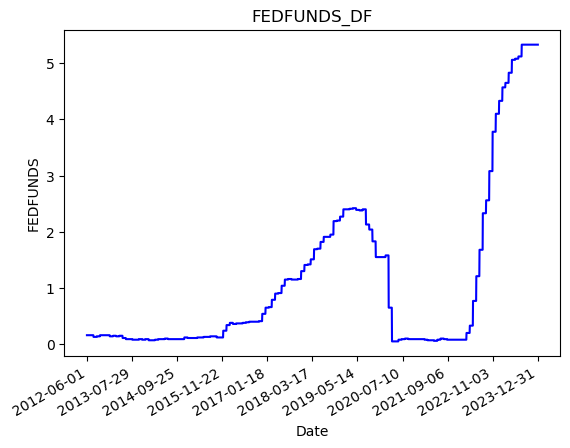

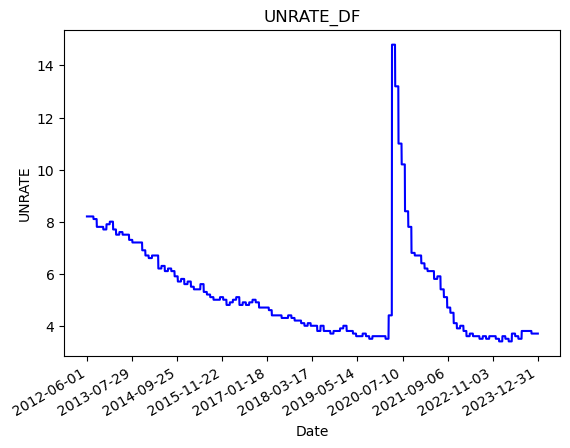

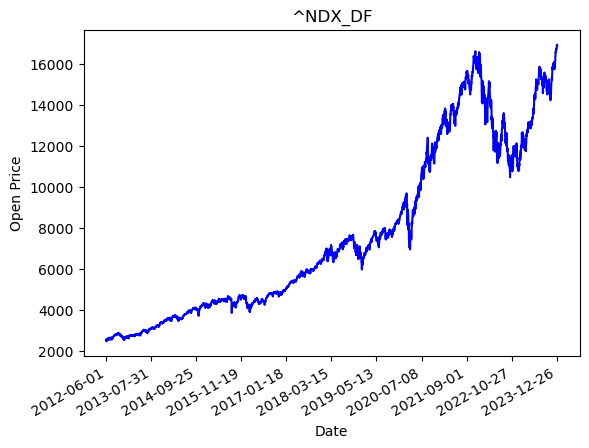

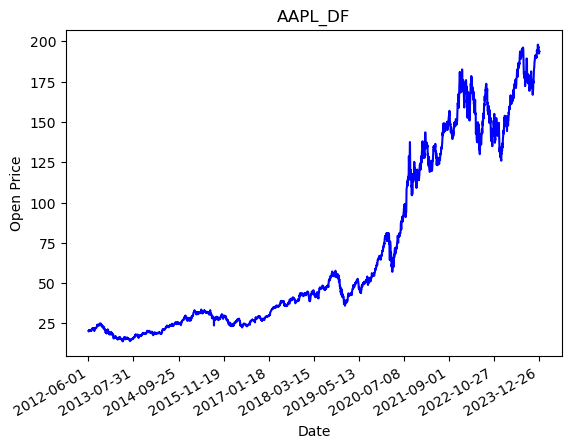

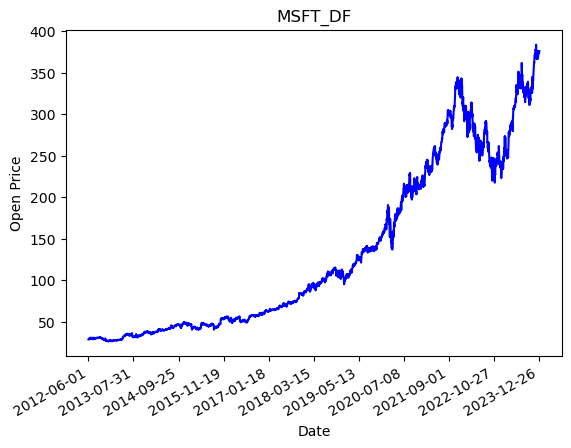

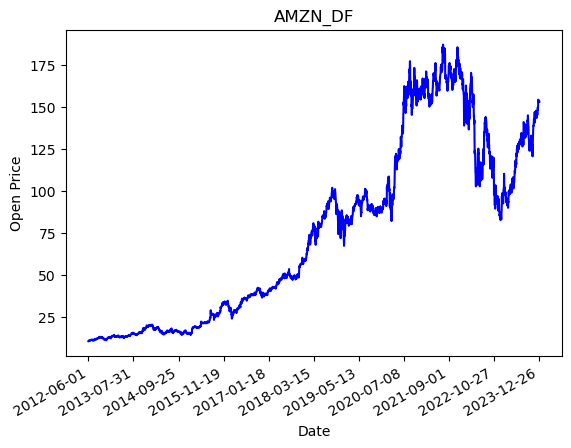

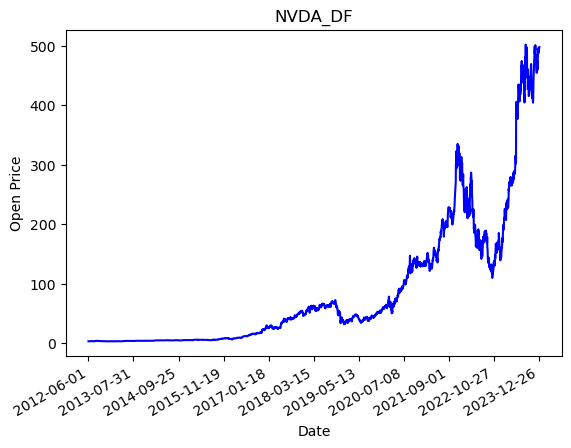

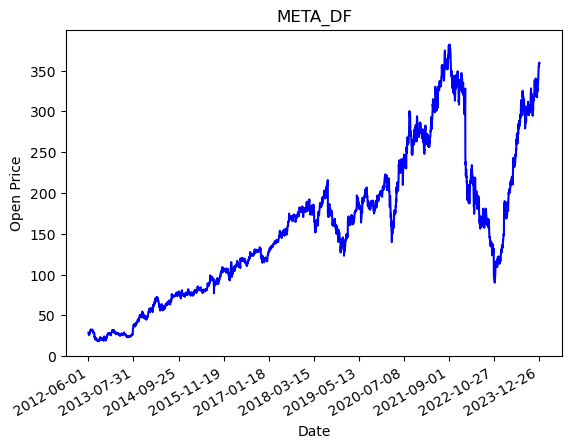

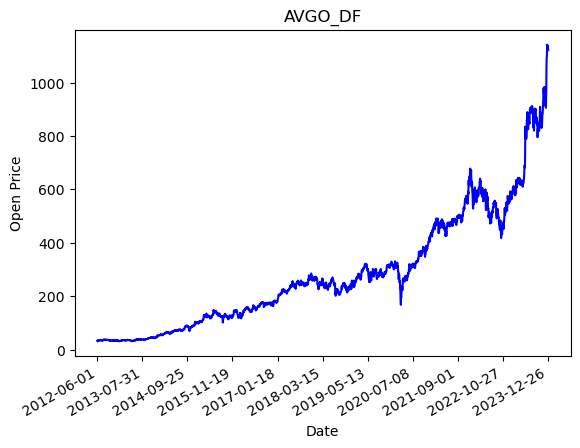

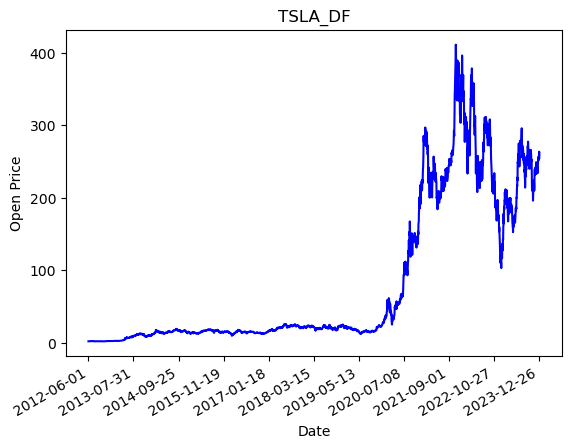

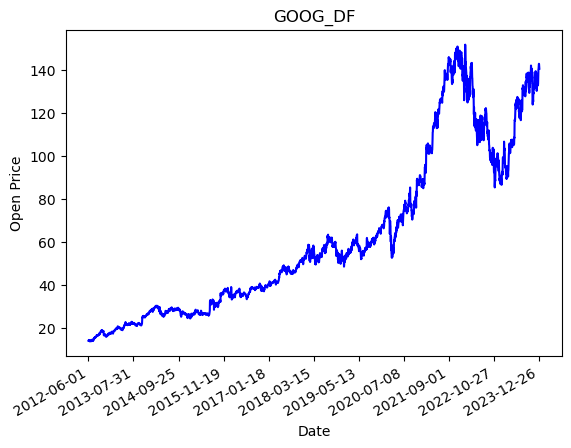

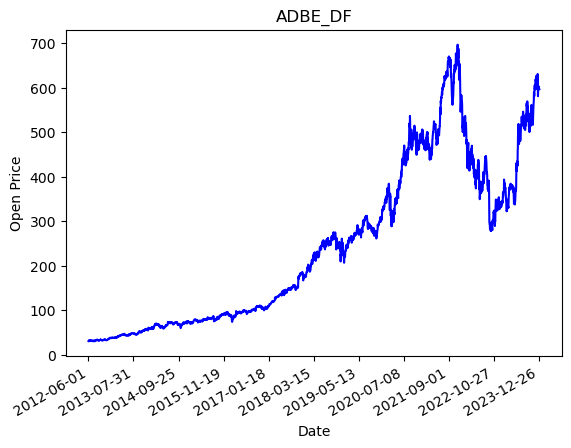

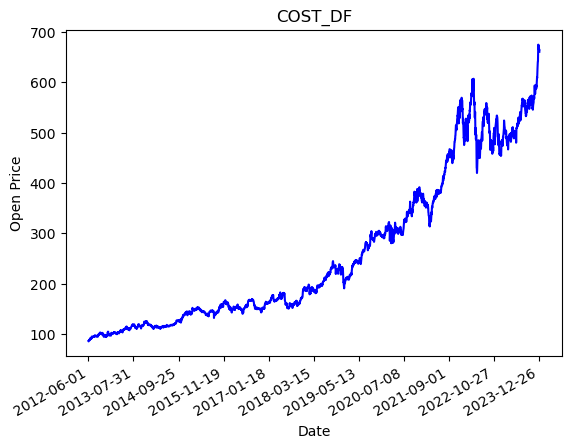

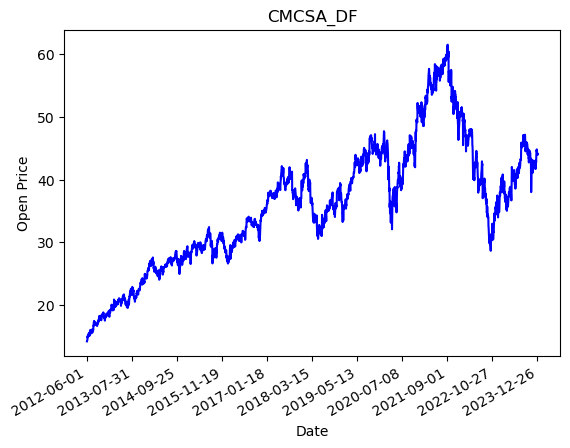

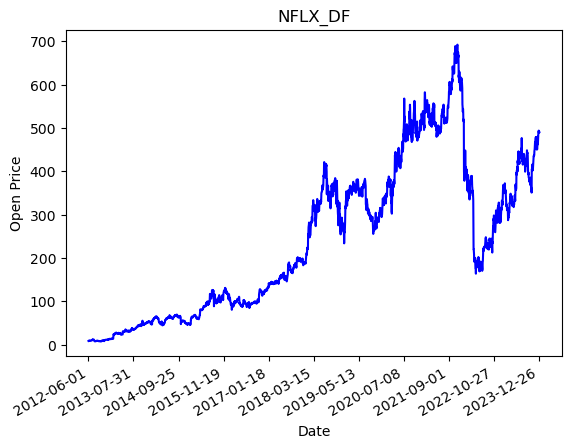

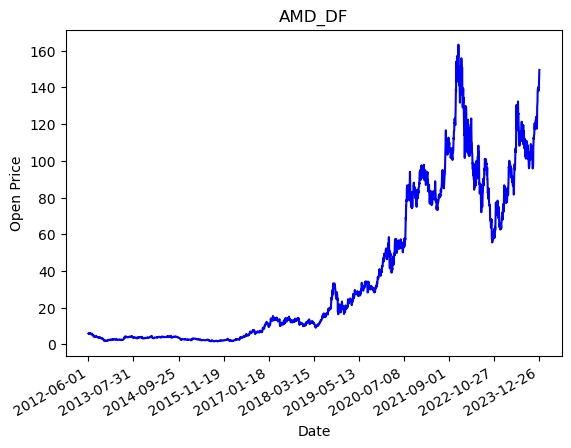

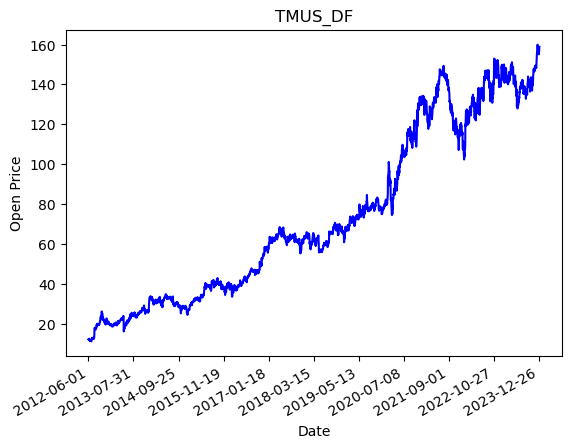

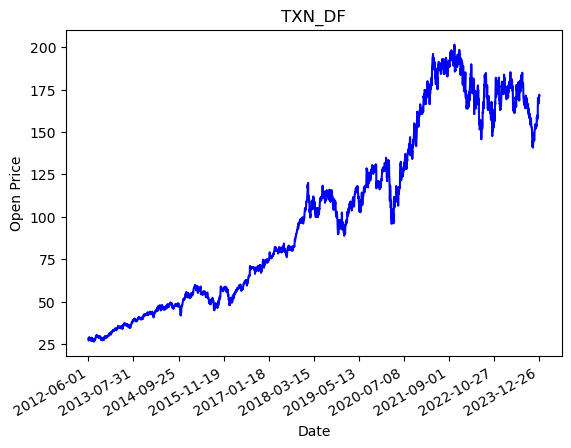

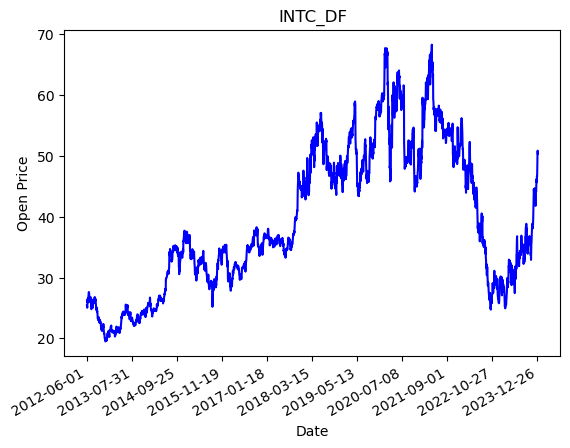

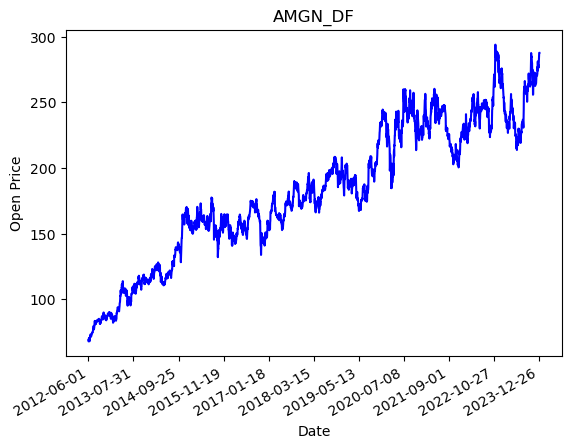

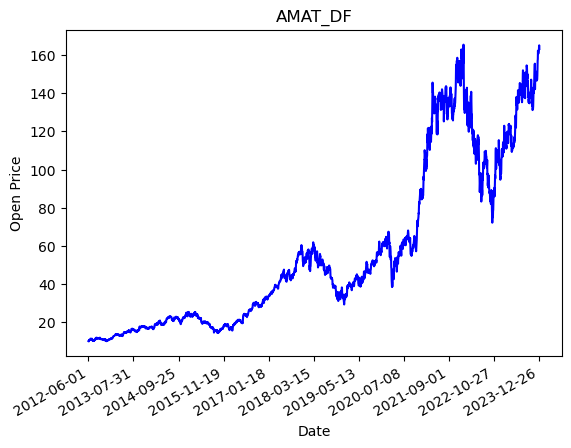

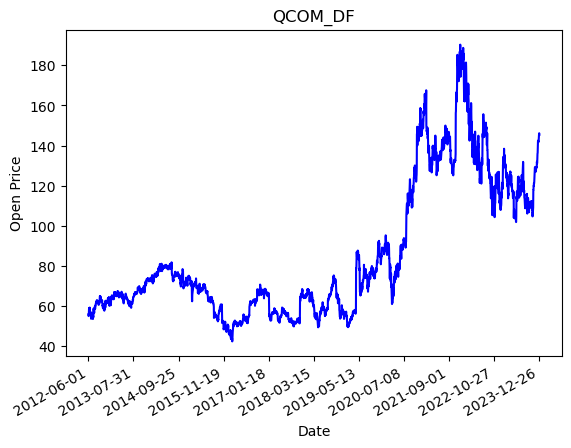

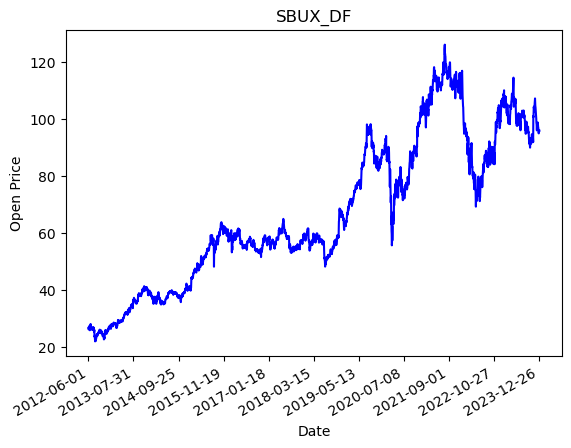

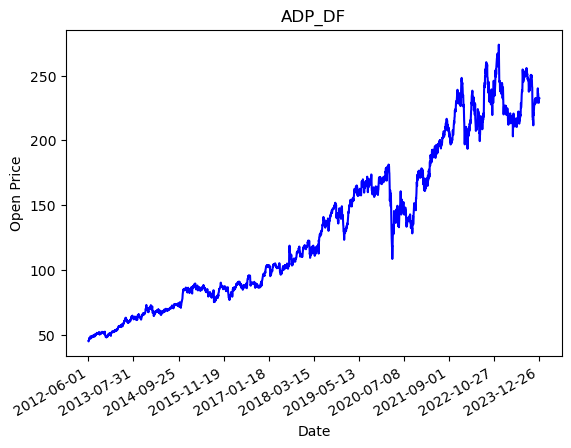

In [11]:
 # Graficaremos cada variable
num_ticks = 10

for df in stocks_dict.keys():
    if df in macros:
        fig, ax = plt.subplots()

        ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,1], linestyle= '-', color='b')

        fig.autofmt_xdate()
        plt.xticks(stocks_dict[df]['Date'][::len(stocks_dict[df]['Date']) // num_ticks])

        plt.title(df)
        plt.xlabel(stocks_dict[df].columns[0])
        plt.ylabel(stocks_dict[df].columns[1])

    if df in stocks:
        fig, ax = plt.subplots()

        ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,1], label= 'Open Price', linestyle= '-', color='b')
        #ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,2], label= 'Close Price', linestyle= '--', color='r')

        fig.autofmt_xdate()
        plt.xticks(stocks_dict[df]['Date'][::len(stocks_dict[df]['Date']) // num_ticks])

        plt.title(df)
        plt.xlabel(stocks_dict[df].columns[0])
        plt.ylabel(stocks_dict[df].columns[1] + ' Price')

plt.show()

Las gráficas anteriores indican que no existen valores atípicos en la variable seleccionada.

**Análisis de cardinalidad.**

Si buscamos determinar la cardinalidad de las variables, podemos afirmar que no hay variables categóricas para analizar. Sin embargo, incluso al intentar analizar la cardinalidad de las variables no categóricas, podemos utilizar las gráficas anteriores para observar que varía de manera diferente en cada empresa, pero en general tiende a ser alta cuando consideramos un plazo de tiempo también extenso.

**Tendencias temporales**

Con base en las gráficas anteriores, también es posible identificar tendencias temporales, las cuales son comunes en este tipo de variables a lo largo del tiempo. Se observa que prácticamente todas las empresas muestran tendencias temporales, como el ejemplo de Amazon, donde se aprecia un crecimiento significativo durante el 2020 y una estabilidad relativa hasta el 2022.

**A continuación, realizaremos un análisis de distribución para cada variable numérica de los dataframes. Este análisis nos permitirá identificar si las variables tienen una distribución normal o si están sesgadas.**

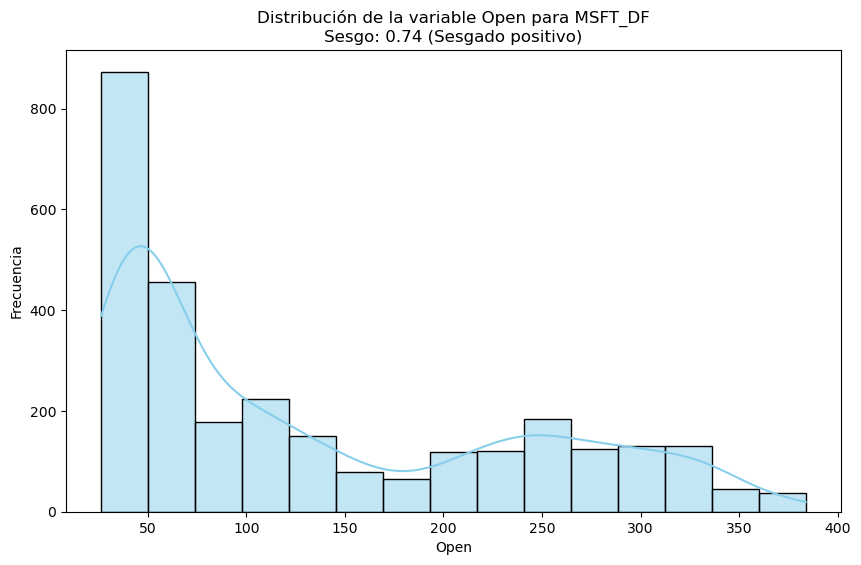

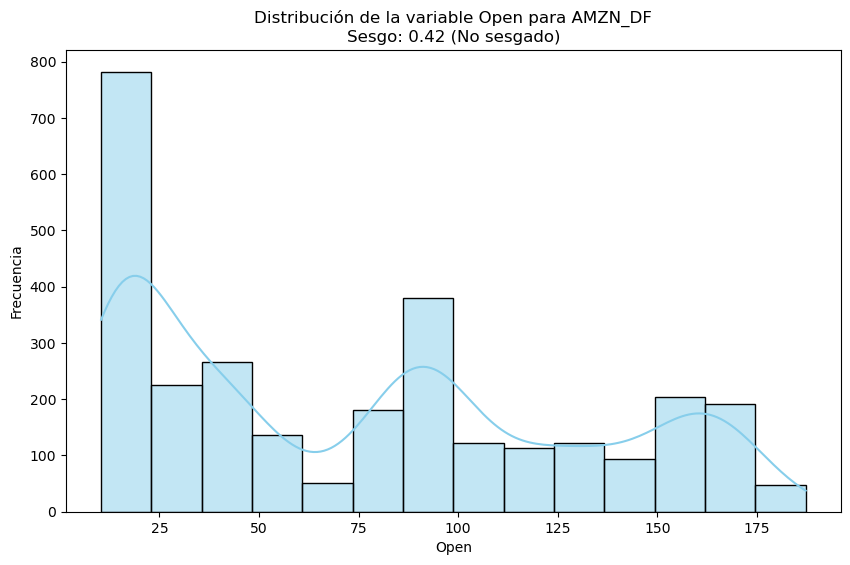

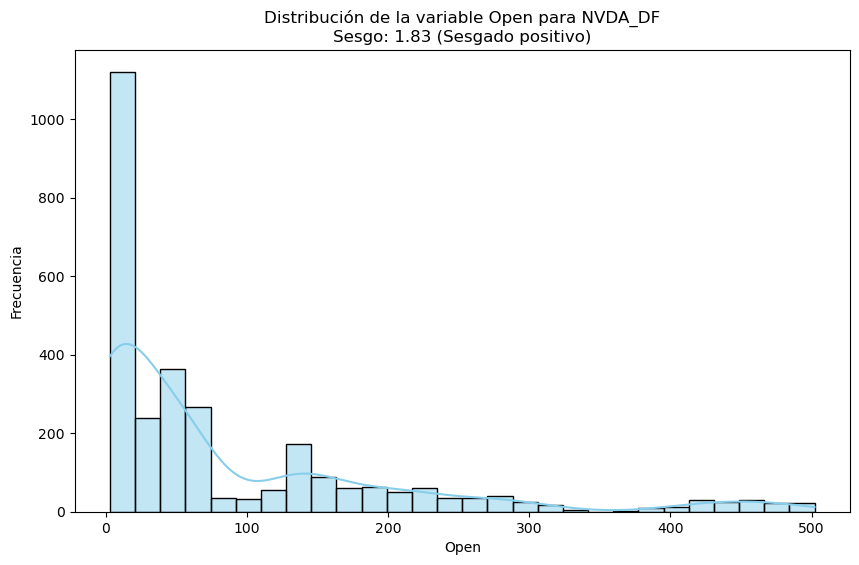

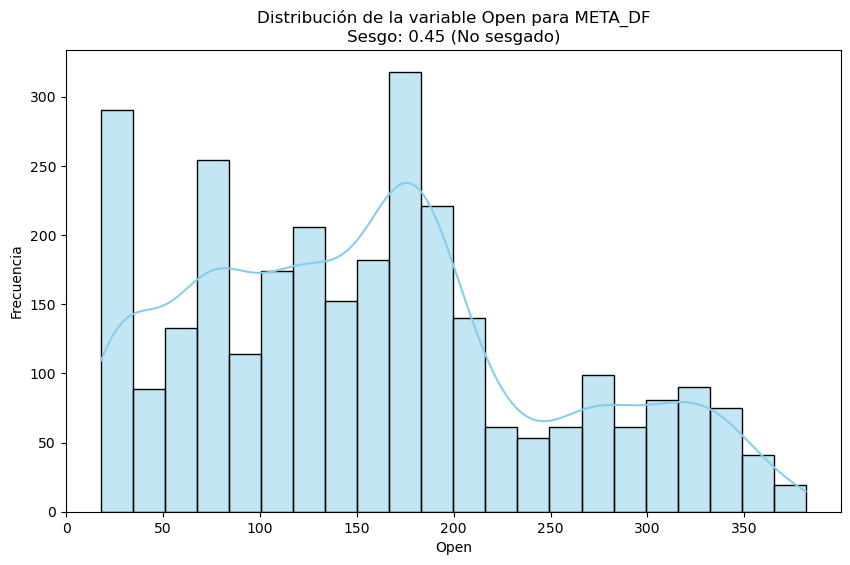

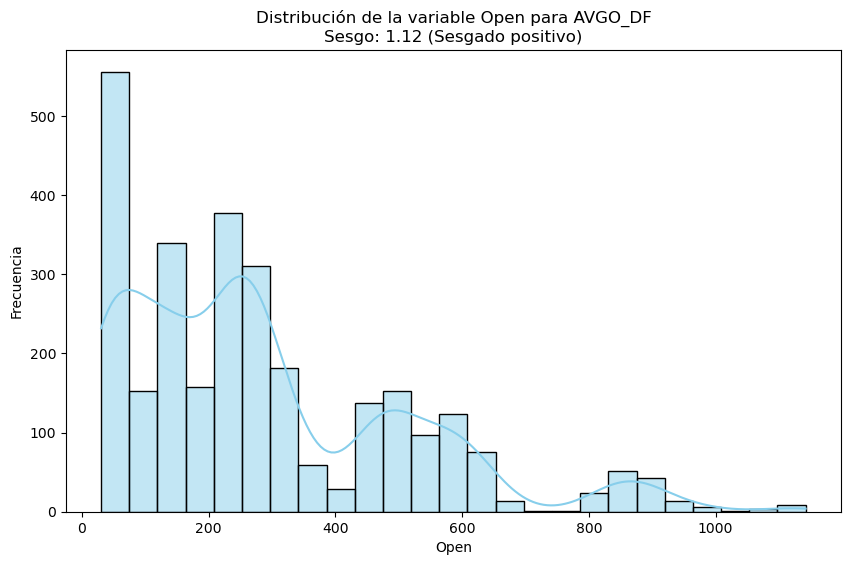

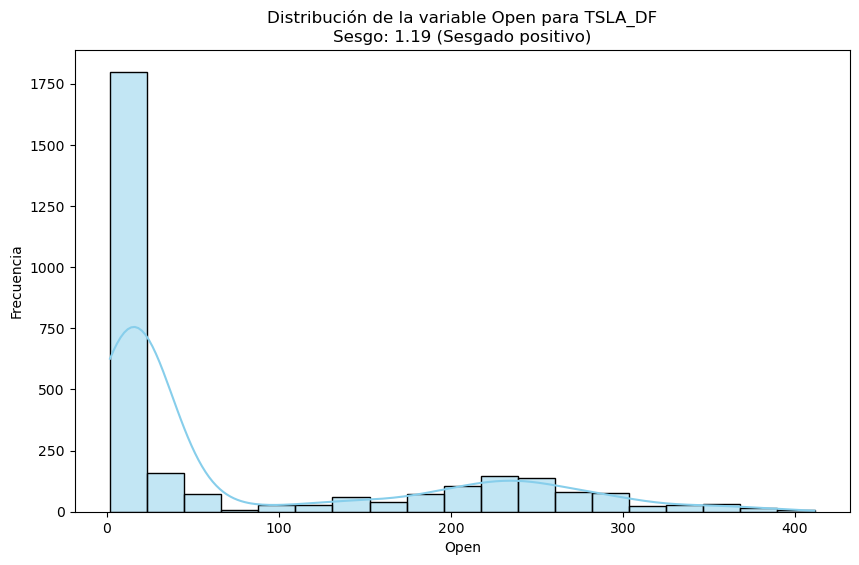

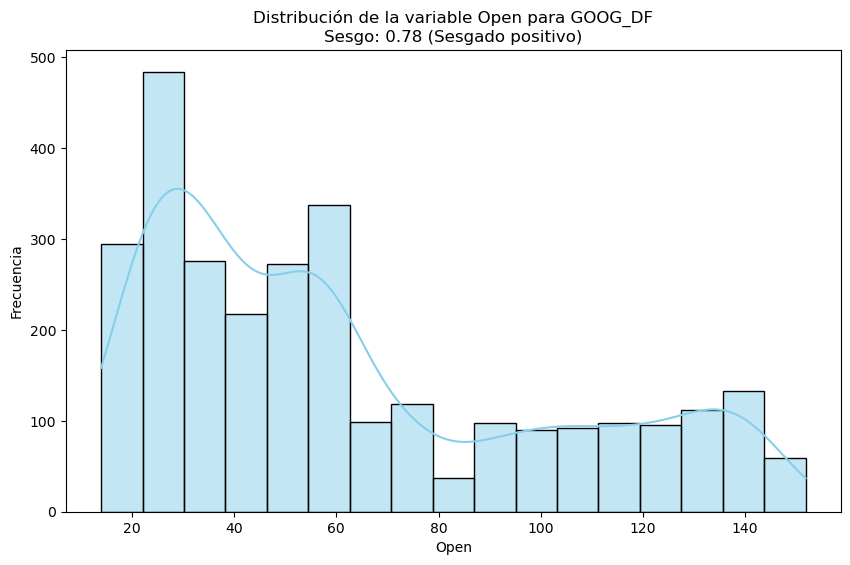

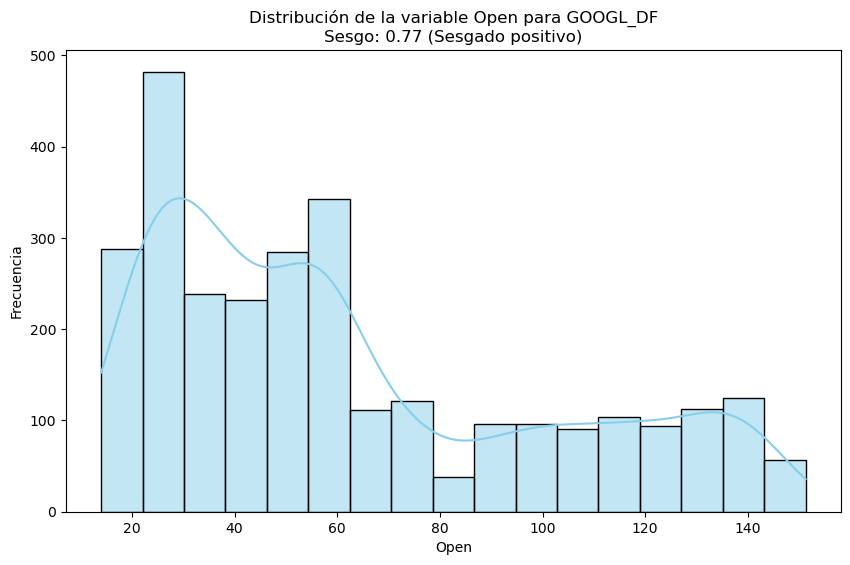

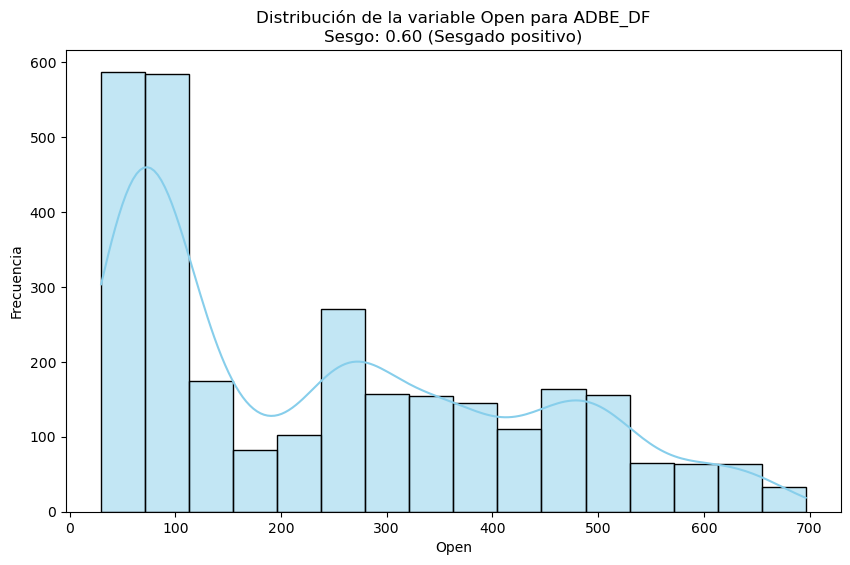

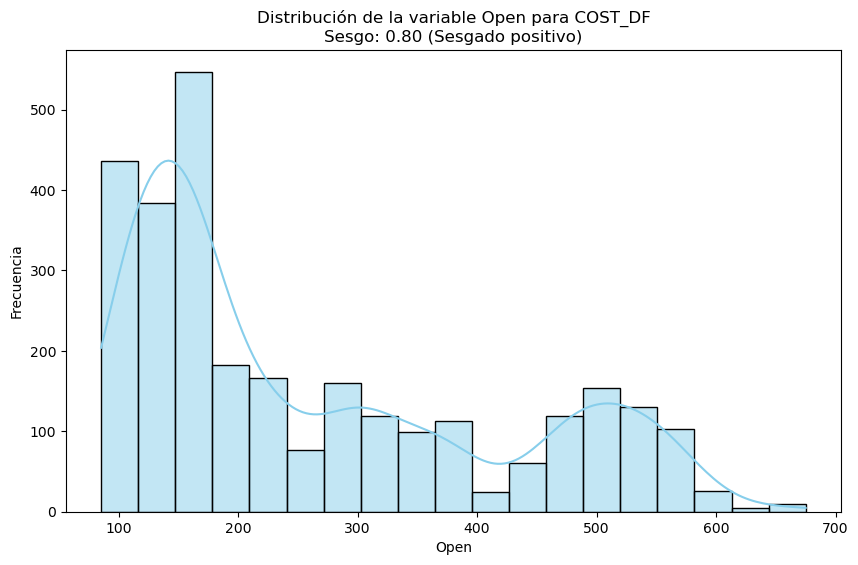

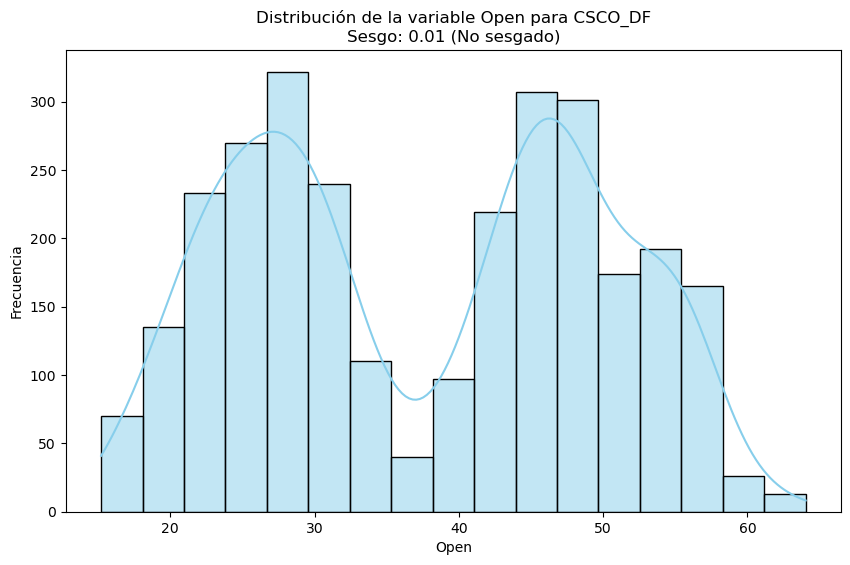

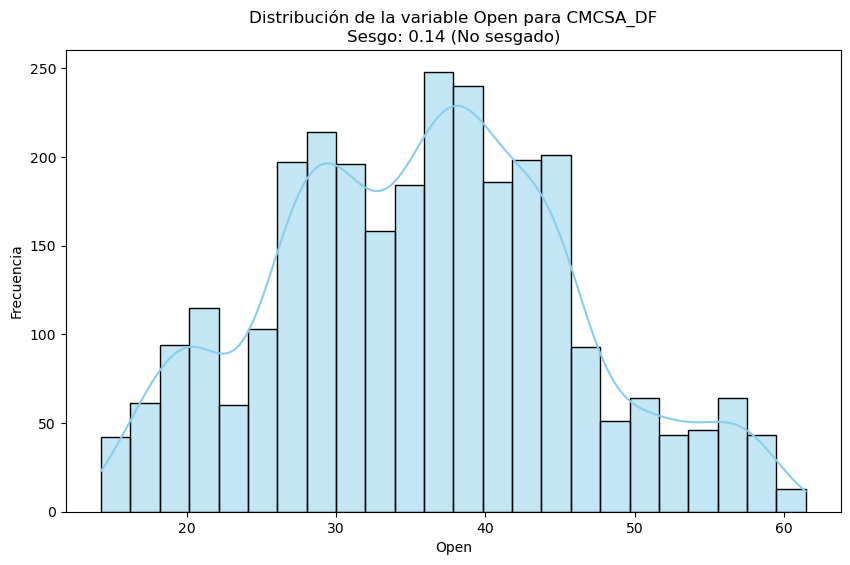

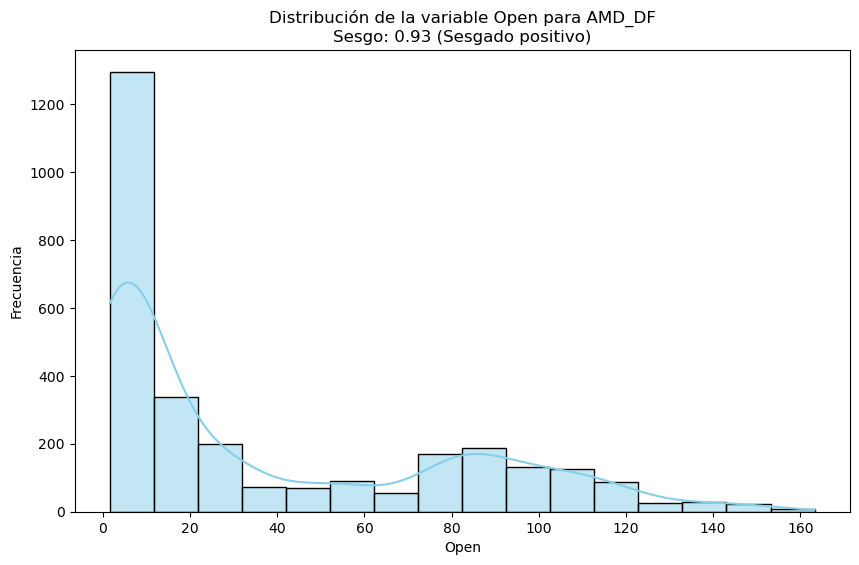

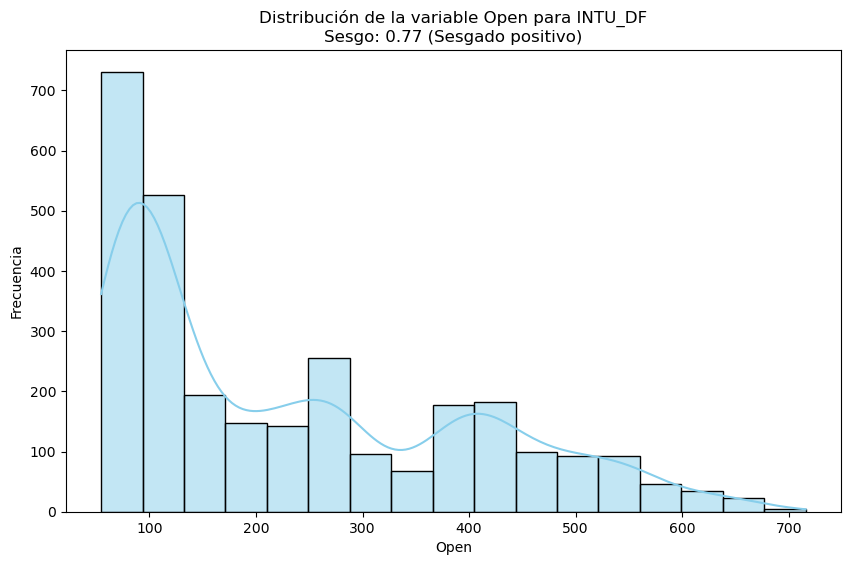

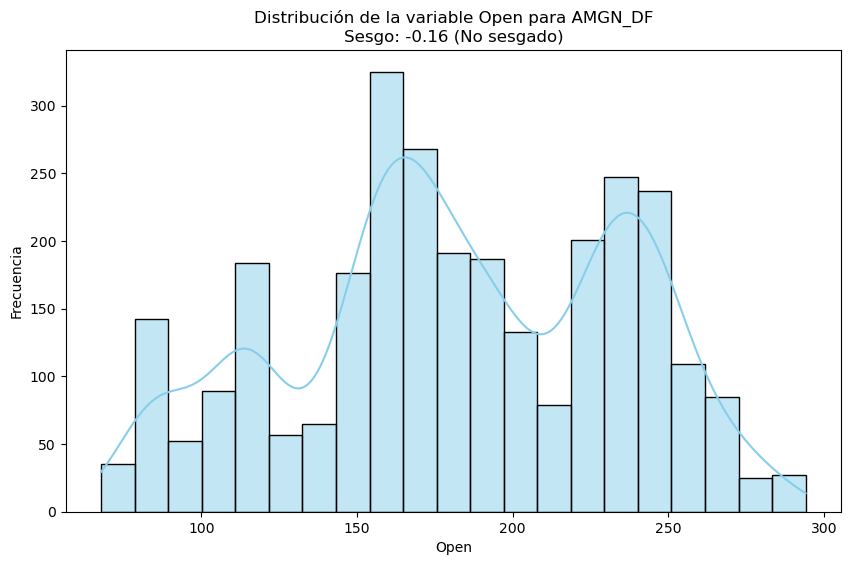

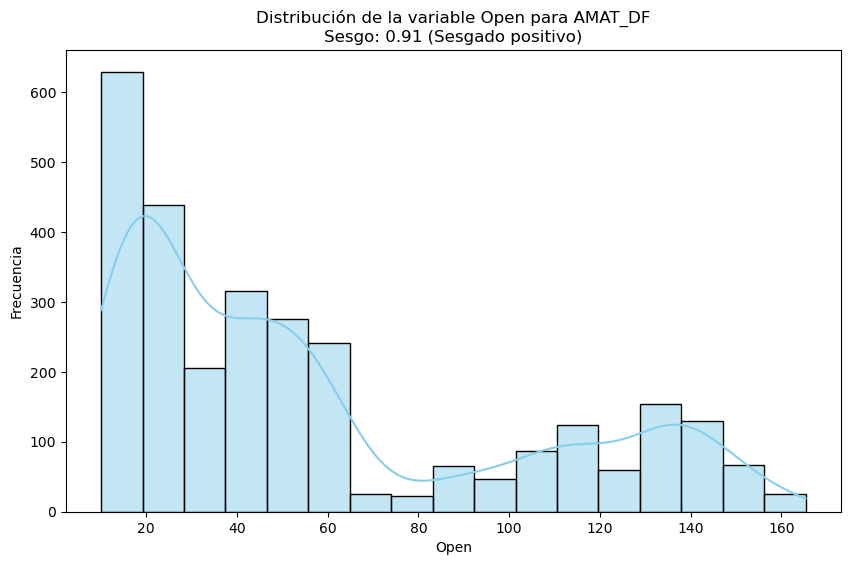

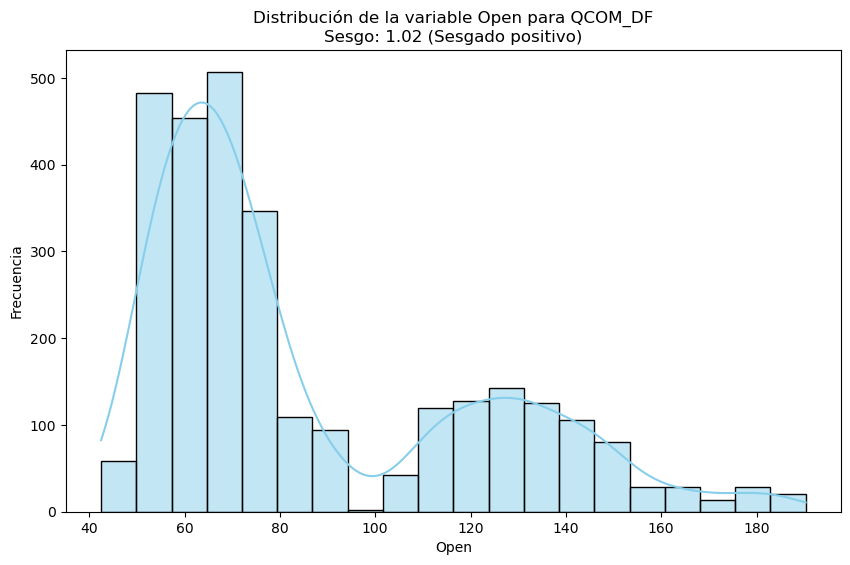

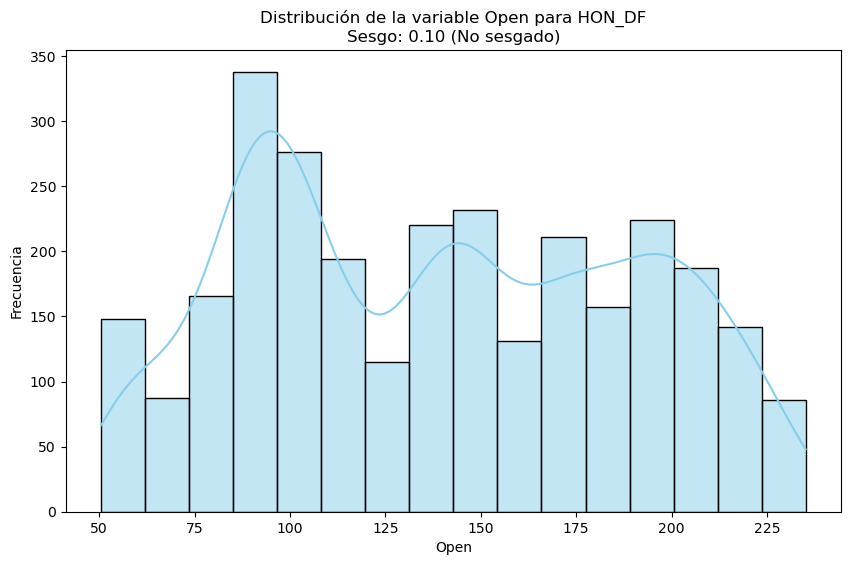

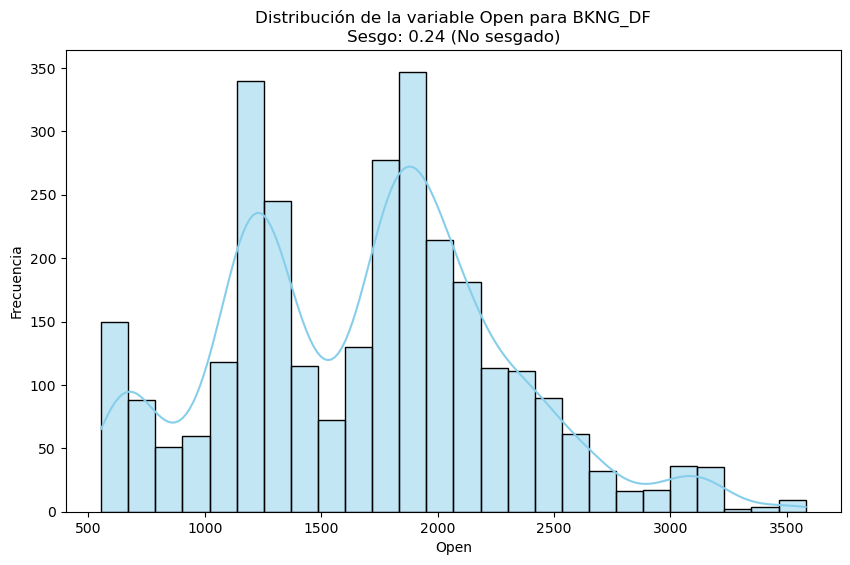

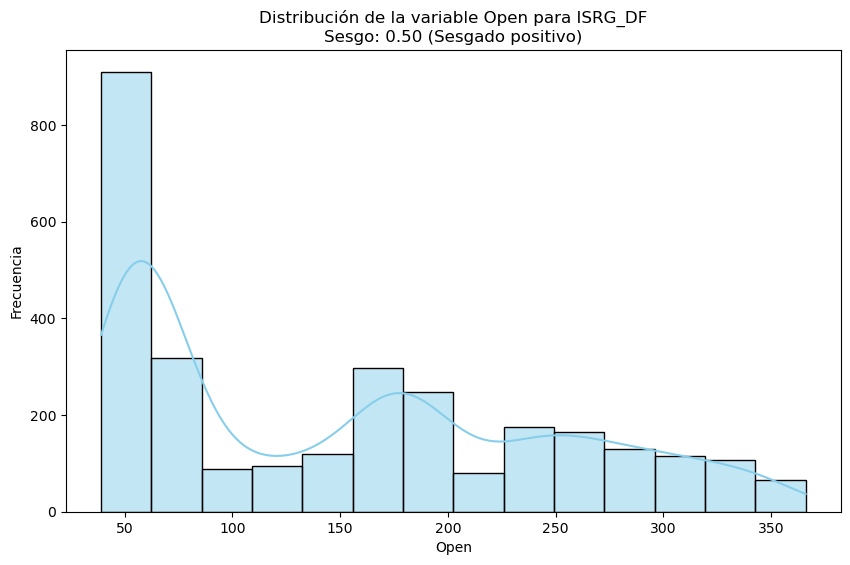

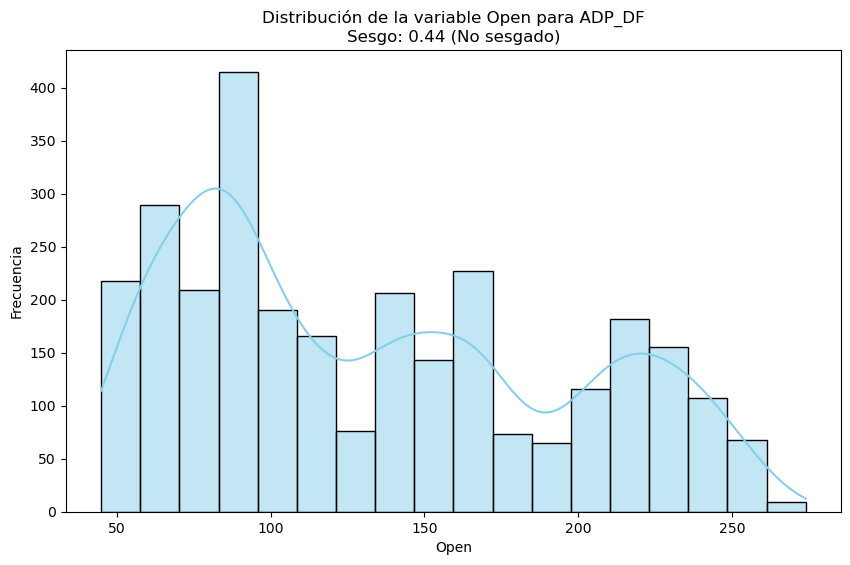

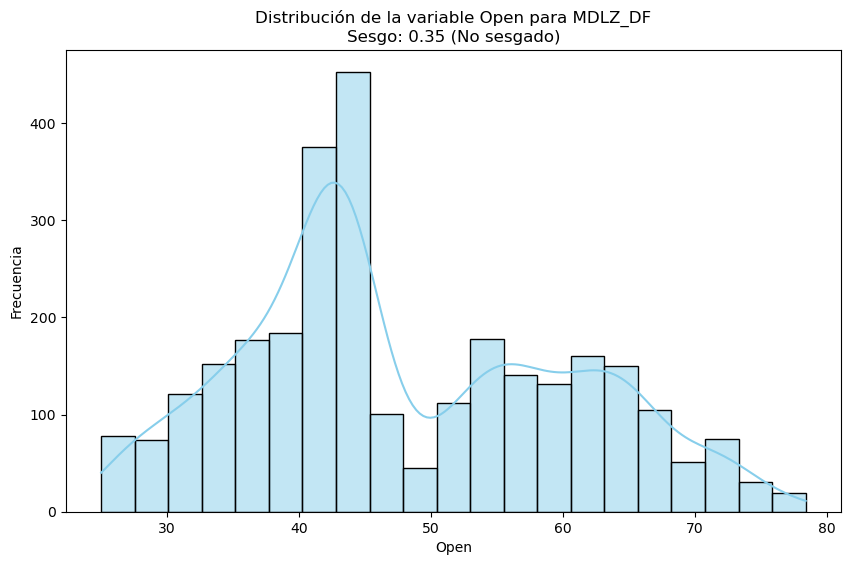

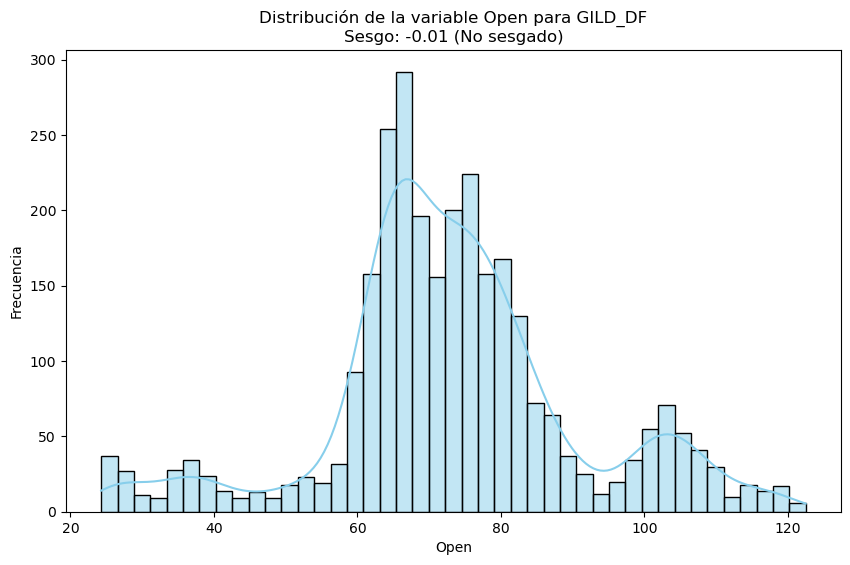

In [12]:
for df in stocks_dict.keys():
  if df in stocks:

    sesgo = skew(stocks_dict[df]['Open'])

    if abs(sesgo) > 0.5:
        tipo_sesgo = "Sesgado positivo"
    elif abs(sesgo) < -0.5:
      tipo_sesgo = "Sesgado negativo"
    else:
        tipo_sesgo = "No sesgado"

    plt.figure(figsize=(10, 6))
    sns.histplot(stocks_dict[df]['Open'], kde=True, color='skyblue')
    plt.title(f'Distribución de la variable Open para {df}\nSesgo: {sesgo:.2f} ({tipo_sesgo})')
    plt.xlabel('Open')
    plt.ylabel('Frecuencia')
    plt.show()



Analizando los resultados, observamos que la mayoría de las variables presentan un sesgo positivo, mientras que una minoría no muestra sesgo alguno.

Por el momento no estaremos realizando transformaciones no lineales a los datos, mas bien buscaremos primero implementar modelos que no usen este requisito, aunque no se descarta que en un futuro se regrese a explorar esta posibilidad para mejorar los modelos

**Análisis de las variables dependientes e independientes.**

A continuación se hará un análisis de correlación sobre las variables identificadas:

In [13]:
# Convertimos las fechas de nuestras variables a un tipo fecha en lugar de objeto
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in stocks:
        stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0])

# Para cada dataframe, asignamos como índice la columna de la fecha
    for df in stocks_dict.keys():
    #    if df in stocks:
            stocks_dict[df].set_index('Date', inplace= True)
            stocks_dict[df].columns = [f'{df}_{col}' for col in stocks_dict[df].columns]

stocks_dict['AAPL_DF'].head()

AAPL_DF_Open  AAPL_DF_High  AAPL_DF_Low  AAPL_DF_Close  \
Date                                                                 
2012-06-01     20.327143     20.451786    20.018572      20.035357   
2012-06-04     20.053572     20.267857    19.589287      20.153214   
2012-06-05     20.045357     20.231071    19.940357      20.101070   
2012-06-06     20.277500     20.494642    20.196428      20.409286   
2012-06-07     20.617500     20.618570    20.375000      20.418571   

            AAPL_DF_Volume  
Date                        
2012-06-01       520987600  
2012-06-04       556995600  
2012-06-05       388214400  
2012-06-06       401455600  
2012-06-07       379766800

Como resultado del análisis se puede observar que las variables de volumen de operación son las que tienen menos correlación contra todas las demas, seguidas de las variables macroeconómicas de la tasa de interés y tasa de desempleo. Finalmente en rojo se aprecian que en general los precios de apertura y cierre de una misma acción tienen una alta correlación mientras también una correlación (un poco más debil) contra precios de otras acciones.

**Distribución de los datos por categorías.**

Al no disponer de variables categóricas, no es posible identificar distribuciones en los datos de manera convencional.

**Patrones o agrupaciones (clusters) de datos.**

La tendencia de los datos utilizados sugiere que no existen patrones o agrupaciones discernibles en este conjunto.

**Normalización de imágenes.**

Para este proyecto no es necesario el uso de imágenes.

**¿Hay desequilibrio en las clases de la variable objetivo?**

Por el momento no se ha definido formalmente una variable objetivo, se pretende realizar la predicción del ^NDX_DF_Open, que representa el precio de apertura del índice bursatil, en el presente análisis todavía se presenta como un valor numérico. Sin embargo en futuras entregas se pretende evaluar si es más conveniente convertirlo en una variable categórica que represente si al día t+1 aumentó o disminuyó su valor respecto al cierre del día t. Esto considerando el objetivo de tener una estrategia de inversión que nos permite identificar qué es más conveniente, si mantener el ETF o venderlo a final de día.

# Ingeniería de características (FE - Feature Engineering)

**Construcción**

Ahora incorporamos una nueva característica a cada conjunto de datos: la variación diaria entre la apertura y el cierre del mercado, con el objetivo de analizar y visualizar esta tendencia.

 La variación diaria entre la apertura y el cierre del mercado es una métrica relevante que puede enriquecer la información disponible para el modelo de predicción de acciones, ofreciendo una perspectiva más detallada sobre la dinámica diaria del mercado de valores.

In [14]:
# A cada DF se le calculará su volatilidad diaria como la diferencia entre las columnas High y Low, dividiendo entre Open
for df in stocks_dict.keys():
    if df in stocks:
        
        vol = (stocks_dict[df].iloc[:, 1].values - stocks_dict[df].iloc[:, 2].values) / stocks_dict[df].iloc[:, 0].values
        stocks_dict[df][df +'_Vola'] = vol

stocks_dict[random.choice(stocks)].head()

QCOM_DF_Open  QCOM_DF_High  QCOM_DF_Low  QCOM_DF_Close  \
Date                                                                 
2012-06-01     55.970001     56.410000    54.849998      55.119999   
2012-06-04     55.119999     55.919998    54.919998      55.849998   
2012-06-05     55.540001     57.299999    55.450001      57.180000   
2012-06-06     57.400002     58.560001    57.250000      58.400002   
2012-06-07     59.139999     59.500000    57.830002      58.000000   

            QCOM_DF_Volume  QCOM_DF_Vola  
Date                                      
2012-06-01        17494600      0.027872  
2012-06-04        12294600      0.018142  
2012-06-05        11730700      0.033309  
2012-06-06        12956000      0.022822  
2012-06-07         9156700      0.028238

In [15]:
# A cada DF le calcularemos el retorno diario como la diferencia entre el Close de hoy y el Close de ayer
for df in stocks_dict.keys():
    if df in stocks:
        
        ret = (stocks_dict[df].iloc[:, 3].values - stocks_dict[df].iloc[:, 3].shift(1).values) / stocks_dict[df].iloc[:, 3].shift(1).values
        stocks_dict[df][df +'_DRet'] = ret

stocks_dict[random.choice(stocks)].head()

CMCSA_DF_Open  CMCSA_DF_High  CMCSA_DF_Low  CMCSA_DF_Close  \
Date                                                                     
2012-06-01         14.285         14.420        14.170          14.315   
2012-06-04         14.350         14.525        14.320          14.475   
2012-06-05         14.450         14.550        14.405          14.515   
2012-06-06         14.565         14.885        14.520          14.880   
2012-06-07         15.050         15.145        14.955          15.005   

            CMCSA_DF_Volume  CMCSA_DF_Vola  CMCSA_DF_DRet  
Date                                                       
2012-06-01         41326800       0.017501            NaN  
2012-06-04         42485600       0.014286       0.011177  
2012-06-05         27511600       0.010035       0.002763  
2012-06-06         26463800       0.025060       0.025146  
2012-06-07         33768800       0.012625       0.008401

In [16]:
# A cada DF le calcularemos la presion a la baja como la diferencia entre High y Close
for df in stocks_dict.keys():
    if df in stocks:
        
        dpre = stocks_dict[df].iloc[:, 1].values - stocks_dict[df].iloc[:, 3].values
        stocks_dict[df][df +'_DPre'] = dpre

stocks_dict[random.choice(stocks)].head()

QCOM_DF_Open  QCOM_DF_High  QCOM_DF_Low  QCOM_DF_Close  \
Date                                                                 
2012-06-01     55.970001     56.410000    54.849998      55.119999   
2012-06-04     55.119999     55.919998    54.919998      55.849998   
2012-06-05     55.540001     57.299999    55.450001      57.180000   
2012-06-06     57.400002     58.560001    57.250000      58.400002   
2012-06-07     59.139999     59.500000    57.830002      58.000000   

            QCOM_DF_Volume  QCOM_DF_Vola  QCOM_DF_DRet  QCOM_DF_DPre  
Date                                                                  
2012-06-01        17494600      0.027872           NaN      1.290001  
2012-06-04        12294600      0.018142      0.013244      0.070000  
2012-06-05        11730700      0.033309      0.023814      0.119999  
2012-06-06        12956000      0.022822      0.021336      0.159999  
2012-06-07         9156700      0.028238     -0.006849      1.500000

In [17]:
# A cada DF le calcularemos la presion a la alza como la diferencia entre Low y Open
for df in stocks_dict.keys():
    if df in stocks:
        
        upre = stocks_dict[df].iloc[:, 2].values - stocks_dict[df].iloc[:, 0].values
        stocks_dict[df][df +'_UPre'] = upre

stocks_dict[random.choice(stocks)].head()

MSFT_DF_Open  MSFT_DF_High  MSFT_DF_Low  MSFT_DF_Close  \
Date                                                                 
2012-06-01     28.760000     28.959999    28.440001      28.450001   
2012-06-04     28.620001     28.780001    28.320000      28.549999   
2012-06-05     28.510000     28.750000    28.389999      28.510000   
2012-06-06     28.879999     29.370001    28.809999      29.350000   
2012-06-07     29.639999     29.700001    29.170000      29.230000   

            MSFT_DF_Volume  MSFT_DF_Vola  MSFT_DF_DRet  MSFT_DF_DPre  \
Date                                                                   
2012-06-01        56634300      0.018081           NaN      0.509998   
2012-06-04        47926300      0.016073      0.003515      0.230002   
2012-06-05        45715400      0.012627     -0.001401      0.240000   
2012-06-06        46860500      0.019391      0.029463      0.020001   
2012-06-07        37792800      0.017881     -0.004089      0.470001   

            MSFT_DF_UPre  
Date                      
2012-06-01     -0.319999  
2012-06-04     -0.300001  
2012-06-05     -0.120001  
2012-06-06     -0.070000  
2012-06-07     -0.469999

In [18]:
# A cada DF le añadiremos un promedio movil sobre Close en ciertos intervalos de tiempo para representar tendencia
# Definimos los dias de tendencia hacia atrás que deseamos revisar
horizons = [5, 10, 20]

# Calculamos el promedio móvil para cada horizonte
for df in stocks_dict.keys():
    if df in stocks:
        
        for h in horizons:
            mave = stocks_dict[df].iloc[:, 3].rolling(h).mean()
            stocks_dict[df][df + '_MAve' + f'{h}'] = mave

stocks_dict[random.choice(stocks)].head()

CSCO_DF_Open  CSCO_DF_High  CSCO_DF_Low  CSCO_DF_Close  \
Date                                                                 
2012-06-01     16.080000     16.150000    15.940000      15.960000   
2012-06-04     15.980000     16.129999    15.920000      16.110001   
2012-06-05     16.059999     16.280001    15.980000      16.120001   
2012-06-06     16.290001     16.690001    16.230000      16.690001   
2012-06-07     16.879999     16.920000    16.530001      16.580000   

            CSCO_DF_Volume  CSCO_DF_Vola  CSCO_DF_DRet  CSCO_DF_DPre  \
Date                                                                   
2012-06-01        48493800      0.013060           NaN      0.190000   
2012-06-04        29743500      0.013141      0.009399      0.019998   
2012-06-05        34648800      0.018680      0.000621      0.160000   
2012-06-06        33224400      0.028238      0.035360      0.000000   
2012-06-07        34270300      0.023104     -0.006591      0.340000   

            CSCO_DF_UPre  CSCO_DF_MAve5  CSCO_DF_MAve10  CSCO_DF_MAve20  
Date                                                                     
2012-06-01     -0.140000            NaN             NaN             NaN  
2012-06-04     -0.060000            NaN             NaN             NaN  
2012-06-05     -0.079999            NaN             NaN             NaN  
2012-06-06     -0.060001            NaN             NaN             NaN  
2012-06-07     -0.349998      16.292001             NaN             NaN

In [19]:
# A cada DF le añadiremos la desviación estándar sobre Close en ciertos intervalos de tiempo para representar variablidad
# Calculamos el promedio móvil para cada horizonte
for df in stocks_dict.keys():
    if df in stocks:
        
        for h in horizons:
            std = stocks_dict[df].iloc[:, 3].rolling(h).std()
            stocks_dict[df][df + '_Std' + f'{h}'] = std

stocks_dict[random.choice(stocks)].head()

GOOGL_DF_Open  GOOGL_DF_High  GOOGL_DF_Low  GOOGL_DF_Close  \
Date                                                                     
2012-06-01      14.309059      14.330581     14.222973       14.288789   
2012-06-04      14.269770      14.526777     14.264515       14.479229   
2012-06-05      14.400651      14.467718     14.175926       14.274525   
2012-06-06      14.426426      14.563814     14.354605       14.528779   
2012-06-07      14.704705      14.711962     14.445696       14.470220   

            GOOGL_DF_Volume  GOOGL_DF_Vola  GOOGL_DF_DRet  GOOGL_DF_DPre  \
Date                                                                       
2012-06-01        122193684       0.007520            NaN       0.041792   
2012-06-04         97210692       0.018379       0.013328       0.047548   
2012-06-05         93502404       0.020262      -0.014138       0.193193   
2012-06-06         83748168       0.014502       0.017812       0.035035   
2012-06-07         70269660       0.018108      -0.004031       0.241742   

            GOOGL_DF_UPre  GOOGL_DF_MAve5  GOOGL_DF_MAve10  GOOGL_DF_MAve20  \
Date                                                                          
2012-06-01      -0.086086             NaN              NaN              NaN   
2012-06-04      -0.005255             NaN              NaN              NaN   
2012-06-05      -0.224725             NaN              NaN              NaN   
2012-06-06      -0.071821             NaN              NaN              NaN   
2012-06-07      -0.259009       14.408308              NaN              NaN   

            GOOGL_DF_Std5  GOOGL_DF_Std10  GOOGL_DF_Std20  
Date                                                       
2012-06-01            NaN             NaN             NaN  
2012-06-04            NaN             NaN             NaN  
2012-06-05            NaN             NaN             NaN  
2012-06-06            NaN             NaN             NaN  
2012-06-07       0.117855             NaN             NaN

Vamos a buscar en específico el ^NDX_DF. Este dataframe contiene en específico el índice bursatil que deseamos predecir. Lo que haremos será agregar una nueva columna que nos indique el precio del día siguiente, posteriormente haremos una comparación entre el precio de cierre y el precio del día siguiente y, con el resultado de la comparación, definiremos la variable objetivo binaria que nos dice si el precio subió o bajó.

In [20]:
# Insertamos columna con el precio de apertura del día siguiente
stocks_dict['^NDX_DF']['^NDX_DF_Tomorrow'] = stocks_dict['^NDX_DF']['^NDX_DF_Open'].shift(-1)

# Insertamos columna binaria que indica si subió o bajó el precio
stocks_dict['^NDX_DF']['^NDX_DF_Target'] = (stocks_dict['^NDX_DF']['^NDX_DF_Tomorrow'] > stocks_dict['^NDX_DF']['^NDX_DF_Close']).astype(int)

# Ya calculado el objetivo, quitaremos de la data la columna de tomorrow para evitar leakage
stocks_dict['^NDX_DF'].drop('^NDX_DF_Tomorrow', axis= 1, inplace= True)

stocks_dict['^NDX_DF'].head()

^NDX_DF_Open  ^NDX_DF_High  ^NDX_DF_Low  ^NDX_DF_Close  \
Date                                                                 
2012-06-01   2510.820068   2510.820068  2458.729980    2458.830078   
2012-06-04   2458.969971   2480.969971  2443.919922    2478.129883   
2012-06-05   2467.810059   2492.530029  2467.659912    2487.500000   
2012-06-06   2504.080078   2546.320068  2504.080078    2546.320068   
2012-06-07   2569.239990   2570.479980  2531.949951    2535.409912   

            ^NDX_DF_Volume  ^NDX_DF_Vola  ^NDX_DF_DRet  ^NDX_DF_DPre  \
Date                                                                   
2012-06-01      1966370000      0.020746           NaN     51.989990   
2012-06-04      1755750000      0.015067      0.007849      2.840088   
2012-06-05      1625600000      0.010078      0.003781      5.030029   
2012-06-06      1761050000      0.016868      0.023646      0.000000   
2012-06-07      1655370000      0.014997     -0.004285     35.070068   

            ^NDX_DF_UPre  ^NDX_DF_MAve5  ^NDX_DF_MAve10  ^NDX_DF_MAve20  \
Date                                                                      
2012-06-01    -52.090088            NaN             NaN             NaN   
2012-06-04    -15.050049            NaN             NaN             NaN   
2012-06-05     -0.150147            NaN             NaN             NaN   
2012-06-06      0.000000            NaN             NaN             NaN   
2012-06-07    -37.290039    2501.237988             NaN             NaN   

            ^NDX_DF_Std5  ^NDX_DF_Std10  ^NDX_DF_Std20  ^NDX_DF_Target  
Date                                                                    
2012-06-01           NaN            NaN            NaN               1  
2012-06-04           NaN            NaN            NaN               0  
2012-06-05           NaN            NaN            NaN               1  
2012-06-06           NaN            NaN            NaN               1  
2012-06-07     37.819512            NaN            NaN               0

Continuamos por unir todos los dataframes en uno solo para armar nuestra variable X

In [21]:
# Generamos dataframe con toda la información junta
# Unimos los dataframes con la fecha como índice
first_key = next(iter(stocks_dict))
first_key

for df in stocks_dict.keys():
    if df == first_key:
        X = stocks_dict[df]
    else:
        X = pd.merge(X, stocks_dict[df], how='left', left_index=True, right_index=True)


# Quitamos las filas donde no habia suficiente información para calcular y tenemos NaN
X = X.dropna()
X.head()

FEDFUNDS_DF_FEDFUNDS  UNRATE_DF_UNRATE  ^NDX_DF_Open  \
Date                                                               
2012-06-28                  0.16               8.2   2565.530029   
2012-06-29                  0.16               8.2   2566.840088   
2012-07-02                  0.16               8.2   2616.520020   
2012-07-03                  0.16               8.2   2623.459961   
2012-07-05                  0.16               8.2   2643.629883   

            ^NDX_DF_High  ^NDX_DF_Low  ^NDX_DF_Close  ^NDX_DF_Volume  \
Date                                                                   
2012-06-28   2565.530029  2510.370117    2536.649902    1.795850e+09   
2012-06-29   2615.820068  2566.840088    2615.719971    2.021190e+09   
2012-07-02   2625.260010  2604.899902    2625.030029    1.845240e+09   
2012-07-03   2645.840088  2621.770020    2645.840088    1.009330e+09   
2012-07-05   2660.260010  2629.909912    2647.469971    1.423990e+09   

            ^NDX_DF_Vola  ^NDX_DF_DRet  ^NDX_DF_DPre  ...  GILD_DF_Vola  \
Date                                                  ...                 
2012-06-28      0.021500     -0.011257     28.880127  ...      0.028538   
2012-06-29      0.019082      0.031171      0.100097  ...      0.018185   
2012-07-02      0.007781      0.003559      0.229981  ...      0.013284   
2012-07-03      0.009175      0.007928      0.000000  ...      0.014361   
2012-07-05      0.011480      0.000616     12.790039  ...      0.015568   

            GILD_DF_DRet  GILD_DF_DPre  GILD_DF_UPre  GILD_DF_MAve5  \
Date                                                                  
2012-06-28     -0.023610      0.580000     -0.709999      25.246000   
2012-06-29      0.024780      0.040001     -0.355000      25.321999   
2012-07-02      0.006825      0.019998     -0.099998      25.457000   
2012-07-03      0.008716      0.009998     -0.084999      25.628000   
2012-07-05     -0.011905      0.345001     -0.344999      25.649000   

            GILD_DF_MAve10  GILD_DF_MAve20  GILD_DF_Std5  GILD_DF_Std10  \
Date                                                                      
2012-06-28       25.219500        24.92025      0.229058       0.197096   
2012-06-29       25.268999        24.98550      0.289840       0.234850   
2012-07-02       25.340000        25.04600      0.337206       0.282293   
2012-07-03       25.407500        25.13525      0.378989       0.359168   
2012-07-05       25.441500        25.19125      0.381681       0.373148   

            GILD_DF_Std20  
Date                       
2012-06-28       0.371669  
2012-06-29       0.378014  
2012-07-02       0.409434  
2012-07-03       0.422282  
2012-07-05       0.423224  

[5 rows x 468 columns]

Como última característica añadiremos una columna que nos indique la cantidad de dias transcurridos entre la observación previa y la actual

In [22]:
# Calcular la diferencia entre las fechas, restar 1 dia (diferencia normal) y tirar filas con NA
X['MissDays'] = (X.index.to_series().diff().dt.days - 1)
X = X.dropna()
X['MissDays'] = X['MissDays'].astype(int)

X.head()

FEDFUNDS_DF_FEDFUNDS  UNRATE_DF_UNRATE  ^NDX_DF_Open  \
Date                                                               
2012-06-29                  0.16               8.2   2566.840088   
2012-07-02                  0.16               8.2   2616.520020   
2012-07-03                  0.16               8.2   2623.459961   
2012-07-05                  0.16               8.2   2643.629883   
2012-07-06                  0.16               8.2   2635.649902   

            ^NDX_DF_High  ^NDX_DF_Low  ^NDX_DF_Close  ^NDX_DF_Volume  \
Date                                                                   
2012-06-29   2615.820068  2566.840088    2615.719971    2.021190e+09   
2012-07-02   2625.260010  2604.899902    2625.030029    1.845240e+09   
2012-07-03   2645.840088  2621.770020    2645.840088    1.009330e+09   
2012-07-05   2660.260010  2629.909912    2647.469971    1.423990e+09   
2012-07-06   2636.959961  2596.100098    2612.290039    1.437420e+09   

            ^NDX_DF_Vola  ^NDX_DF_DRet  ^NDX_DF_DPre  ...  GILD_DF_DRet  \
Date                                                  ...                 
2012-06-29      0.019082      0.031171      0.100097  ...      0.024780   
2012-07-02      0.007781      0.003559      0.229981  ...      0.006825   
2012-07-03      0.009175      0.007928      0.000000  ...      0.008716   
2012-07-05      0.011480      0.000616     12.790039  ...     -0.011905   
2012-07-06      0.015503     -0.013288     24.669922  ...     -0.009716   

            GILD_DF_DPre  GILD_DF_UPre  GILD_DF_MAve5  GILD_DF_MAve10  \
Date                                                                    
2012-06-29      0.040001     -0.355000      25.321999       25.268999   
2012-07-02      0.019998     -0.099998      25.457000       25.340000   
2012-07-03      0.009998     -0.084999      25.628000       25.407500   
2012-07-05      0.345001     -0.344999      25.649000       25.441500   
2012-07-06      0.385000     -0.355002      25.741000       25.493500   

            GILD_DF_MAve20  GILD_DF_Std5  GILD_DF_Std10  GILD_DF_Std20  \
Date                                                                     
2012-06-29        24.98550      0.289840       0.234850       0.378014   
2012-07-02        25.04600      0.337206       0.282293       0.409434   
2012-07-03        25.13525      0.378989       0.359168       0.422282   
2012-07-05        25.19125      0.381681       0.373148       0.423224   
2012-07-06        25.24025      0.208159       0.332625       0.394754   

            MissDays  
Date                  
2012-06-29         0  
2012-07-02         2  
2012-07-03         0  
2012-07-05         1  
2012-07-06         0  

[5 rows x 469 columns]

Finalmente separaremos nuestra columna objetivo para generar el dataframe Y

In [23]:
# Separamos nuestros dataframe en variables independientes (X) y dependientes/objetivo (Y)
Y = X.pop('^NDX_DF_Target').to_frame().astype(int)

Y.head()

^NDX_DF_Target
Date                      
2012-06-29               1
2012-07-02               0
2012-07-03               0
2012-07-05               0
2012-07-06               0

# Partición de la data

Previo a comenzar a revisar cada una de la variables y de evaluar si deben permanecer en el modelo o no, realizaremos la partición de la data en entrenamiento (70%), pruebas (20%) y validación (10%)

In [24]:
# Definimos nuestra partición objetivo y calculamos su posición en nuestra data
q_tt = 0.7
q_test = 0.2
q_val = 1 - (q_tt + q_test)

q_70 = int(len(X) * q_tt)
q_90 = int(len(X) * (q_tt + q_test))

X_tt, y_tt = X[:q_70], Y[:q_70]
X_test, y_test = X[q_70:q_90], Y[q_70:q_90]
X_val, y_val = X[q_90:], Y[q_90:]

var_names = X_tt.columns.tolist()

In [25]:
# Convertimos la variable objetivo a un arreglo de 1 dimension, ya que varios modelos lo requieren así
y_tt = y_tt.iloc[:,0].values
y_test = y_test.iloc[:,0].values
y_val = y_val.iloc[:,0].values

print(y_tt)
print(y_test)
print(y_val)

[1 0 0 ... 0 1 1]
[1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 0 0 0 1 1
 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1
 1 1 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 0 0 1 1 0 1 1 1 0 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1
 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 0 0 0 1 1 1 0 0 1 0 0 1 1
 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 0 1 0
 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 0 0 1 0
 0 1 1 0 1 0 1 1 1 0 1 0 0 0 0 1 1 1 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1 0 0 0 1
 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1
 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 1 1 1 0 0 1 1 0
 0 1 0 0 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 0 1 0 1 0 0 1 1 0
 0 0 0 1 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1
 0 1 1 

In [26]:
# Visualizamos los indices para validar que siga ordenada la data
X_tt.index

DatetimeIndex(['2012-06-29', '2012-07-02', '2012-07-03', '2012-07-05',
               '2012-07-06', '2012-07-09', '2012-07-10', '2012-07-11',
               '2012-07-12', '2012-07-13',
               ...
               '2020-07-06', '2020-07-07', '2020-07-08', '2020-07-09',
               '2020-07-10', '2020-07-13', '2020-07-14', '2020-07-15',
               '2020-07-16', '2020-07-17'],
              dtype='datetime64[ns]', name='Date', length=2025, freq=None)

In [27]:
# Visualizamos los indices para validar que siga ordenada la data
X_test.index

DatetimeIndex(['2020-07-20', '2020-07-21', '2020-07-22', '2020-07-23',
               '2020-07-24', '2020-07-27', '2020-07-28', '2020-07-29',
               '2020-07-30', '2020-07-31',
               ...
               '2022-10-20', '2022-10-21', '2022-10-24', '2022-10-25',
               '2022-10-26', '2022-10-27', '2022-10-28', '2022-10-31',
               '2022-11-01', '2022-11-02'],
              dtype='datetime64[ns]', name='Date', length=579, freq=None)

In [28]:
# Visualizamos los indices para validar que siga ordenada la data
X_val.index

DatetimeIndex(['2022-11-03', '2022-11-04', '2022-11-07', '2022-11-08',
               '2022-11-09', '2022-11-10', '2022-11-11', '2022-11-14',
               '2022-11-15', '2022-11-16',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=290, freq=None)

Ahora realizamos las particiones para el cross validation dentro del conjunto de entrenamiento/pruebas

In [29]:
# Separamos la data
tscv = TimeSeriesSplit(n_splits = 5)
print(tscv)

for i, (train_index, test_index) in enumerate(tscv.split(X_tt)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
#     print(f"  Test:  index={test_index}")

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 

# Estandarización y Normalización

A continuación vamos a realizar una estandarización para que todas las variables independientes se encuentren con una media de 0 y una desviación estándar de 1. Tras varias iteraciones se determinó que en general da mejores resultados utilizar solamente escalado

In [30]:
# Iniciamos el escalador y ajustamos sobre nuestra información
std_scaler = 'NA'

std_scaler = StandardScaler()

X_std1 = pd.DataFrame(std_scaler.fit_transform(X_tt), columns=X_tt.columns, index= X_tt.index)
X_std2 = pd.DataFrame(std_scaler.transform(X_test), columns=X_test.columns, index= X_test.index)
X_std3 = pd.DataFrame(std_scaler.transform(X_val), columns=X_val.columns, index= X_val.index)

X_tt = X_std1
X_test = X_std2
X_val = X_std3

X_tt.head()

FEDFUNDS_DF_FEDFUNDS  UNRATE_DF_UNRATE  ^NDX_DF_Open  \
Date                                                               
2012-06-29             -0.744439          1.372297     -1.427640   
2012-07-02             -0.744439          1.372297     -1.401600   
2012-07-03             -0.744439          1.372297     -1.397962   
2012-07-05             -0.744439          1.372297     -1.387390   
2012-07-06             -0.744439          1.372297     -1.391572   

            ^NDX_DF_High  ^NDX_DF_Low  ^NDX_DF_Close  ^NDX_DF_Volume  \
Date                                                                   
2012-06-29     -1.406350    -1.422451      -1.401756       -0.092362   
2012-07-02     -1.401446    -1.402321      -1.396880       -0.357879   
2012-07-03     -1.390755    -1.393399      -1.385983       -1.619308   
2012-07-05     -1.383264    -1.389093      -1.385129       -0.993566   
2012-07-06     -1.395368    -1.406975      -1.403552       -0.973299   

            ^NDX_DF_Vola  ^NDX_DF_DRet  ^NDX_DF_DPre  ...  GILD_DF_DRet  \
Date                                                  ...                 
2012-06-29      0.803458      2.509505     -0.624871  ...      1.314319   
2012-07-02     -0.482698      0.229333     -0.622206  ...      0.333261   
2012-07-03     -0.324090      0.590064     -0.626926  ...      0.436559   
2012-07-05     -0.061687     -0.013720     -0.364408  ...     -0.690164   
2012-07-06      0.396109     -1.161920     -0.120571  ...     -0.570583   

            GILD_DF_DPre  GILD_DF_UPre  GILD_DF_MAve5  GILD_DF_MAve10  \
Date                                                                    
2012-06-29     -0.948798      0.588531      -2.517715       -2.512054   
2012-07-02     -0.971923      0.845300      -2.510869       -2.508461   
2012-07-03     -0.983483      0.860402      -2.502197       -2.505045   
2012-07-05     -0.596202      0.598601      -2.501132       -2.503324   
2012-07-06     -0.549961      0.588529      -2.496466       -2.500692   

            GILD_DF_MAve20  GILD_DF_Std5  GILD_DF_Std10  GILD_DF_Std20  \
Date                                                                     
2012-06-29       -2.508599     -0.972950      -1.308023      -1.442502   
2012-07-02       -2.505551     -0.917682      -1.260659      -1.416388   
2012-07-03       -2.501055     -0.868927      -1.183911      -1.405708   
2012-07-05       -2.498233     -0.865786      -1.169954      -1.404926   
2012-07-06       -2.495765     -1.068260      -1.210410      -1.428589   

            MissDays  
Date                  
2012-06-29 -0.516756  
2012-07-02  1.768029  
2012-07-03 -0.516756  
2012-07-05  0.625636  
2012-07-06 -0.516756  

[5 rows x 468 columns]

Se utilizará una normalización basada en MinMax con la finalidad de evitar que los rangos de ciertas variables tengan mayor peso que otras.

In [31]:
# Inicializamos el escalador y ajustamos sobre nuestra información
nor_scaler= 'NA'

#nor_scaler = MinMaxScaler()

#X_nor1 = pd.DataFrame(nor_scaler.fit_transform(X_tt), columns= X_tt.columns, index= X_tt.index)
#X_nor2 = pd.DataFrame(nor_scaler.transform(X_test), columns= X_test.columns, index= X_test.index)
#X_nor3 = pd.DataFrame(nor_scaler.transform(X_val), columns= X_val.columns, index= X_val.index)


#X_tt = X_nor1
#X_test = X_nor2
#X_val = X_nor3

#X_tt.head()

# Selección y extracción de características

Como primer paso utilizaremos un umbral de varianza para eliminar todas las variables que no tienen varianza, motivo por el cual su aportación al modelo sería nula

In [32]:
# Iniciamos objeto VarThr y calculamos la varianza, actualizamos X solo con las variables relevantes
VarThr = VarianceThreshold(threshold=1)
VarThr.fit(X_tt)

var_names = X_tt.columns[VarThr.get_support()]
X_tt = X_tt[var_names]
X_tt.head(5)

UNRATE_DF_UNRATE  ^NDX_DF_DPre  ^NDX_DF_MAve5  ^NDX_DF_MAve20  \
Date                                                                        
2012-06-29          1.372297     -0.624871      -1.431551       -1.436484   
2012-07-02          1.372297     -0.622206      -1.421935       -1.432577   
2012-07-03          1.372297     -0.626926      -1.411846       -1.428366   
2012-07-05          1.372297     -0.364408      -1.403234       -1.425676   
2012-07-06          1.372297     -0.120571      -1.395284       -1.423631   

            AAPL_DF_DRet  AAPL_DF_Std5  AAPL_DF_Std10  AAPL_DF_Std20  \
Date                                                                   
2012-06-29      1.449016     -0.590357      -0.736487      -0.905827   
2012-07-02      0.781207     -0.322742      -0.679602      -0.884870   
2012-07-03      0.611968     -0.122809      -0.566871      -0.848983   
2012-07-05      0.951450      0.091754      -0.359604      -0.749626   
2012-07-06     -0.433209     -0.271369      -0.270194      -0.699836   

            MSFT_DF_High  MSFT_DF_UPre  ...  ADP_DF_DRet  ADP_DF_UPre  \
Date                                    ...                             
2012-06-29     -0.994006      0.384822  ...     1.872120     0.581969   
2012-07-02     -0.995610      0.288610  ...     0.079740     0.663662   
2012-07-03     -0.992401      0.625354  ...     0.255862     0.433431   
2012-07-05     -0.991943      0.481035  ...     0.543029     0.641383   
2012-07-06     -0.993776      0.048082  ...    -1.339953     0.084370   

            ADP_DF_MAve10  MDLZ_DF_Open  MDLZ_DF_Vola  MDLZ_DF_DPre  \
Date                                                                  
2012-06-29      -1.462247     -0.448011      0.149243     -1.003231   
2012-07-02      -1.460639     -0.417993     -0.017563     -0.944300   
2012-07-03      -1.459348     -0.345678     -0.322931     -0.738055   
2012-07-05      -1.456522     -0.300651     -0.614626      0.234263   
2012-07-06      -1.454353     -0.318389     -0.866674     -0.355020   

            GILD_DF_MAve5  GILD_DF_MAve10  GILD_DF_MAve20  GILD_DF_Std5  
Date                                                                     
2012-06-29      -2.517715       -2.512054       -2.508599     -0.972950  
2012-07-02      -2.510869       -2.508461       -2.505551     -0.917682  
2012-07-03      -2.502197       -2.505045       -2.501055     -0.868927  
2012-07-05      -2.501132       -2.503324       -2.498233     -0.865786  
2012-07-06      -2.496466       -2.500692       -2.495765     -1.068260  

[5 rows x 138 columns]

Utilizaremos Recursive Feature Elimination, para ir generando modelos y eliminar en cada iteración la variable que haya aportado menos. Esto nos permitirá ir paso a paso buscando evitar que cambie completamente la explicabilidad de los modelos al sustraer un gran número de variables

In [33]:
#### SOLO CORRER ESTAS LINEAS CUANDO CAMBIEN LAS EMPRESAS O TAMAÑO DE LA MUESTRA #######
# Definimos los números de variables con los que deseamos quedarnos, inicializamos y ejecutamos
obj_feats= [10, 15, 20, 30, 40]
feats_ls= []
ranks_ls= []

for i in obj_feats:    
   # Iniciamos objeto RFE y ajustamos
    rfe = RFE(estimator= RandomForestClassifier(random_state= 42, n_jobs= -1),
             n_features_to_select= i,
             step=1 )
    rfe.fit(X_tt, y_tt)
    
    # Recuperamos variables seleccionadas
    sel_feats = X_tt.columns[rfe.support_]
   
    # Obtenemos ranking de todas las variables con su nombre y ordenamos
    ranks = rfe.ranking_

    data = {'ranks': ranks,
           'feats': var_names}
    var_ranks = pd.DataFrame(data, index= var_names)
    var_ranks = var_ranks.sort_values(by='ranks')
   
    feats_ls.append(var_ranks.loc[sel_feats].iloc[:,1].values)
    ranks_ls.append(var_ranks.loc[sel_feats].iloc[:,0].values)
   
print(feats_ls)

[array(['AVGO_DF_Std10', 'TSLA_DF_Std5', 'GOOG_DF_DPre', 'COST_DF_DRet',
       'CMCSA_DF_DRet', 'CMCSA_DF_Std5', 'NFLX_DF_DRet', 'AMD_DF_DRet',
       'INTC_DF_Std20', 'ISRG_DF_Volume'], dtype=object), array(['AVGO_DF_Volume', 'AVGO_DF_Std10', 'TSLA_DF_Std5', 'GOOG_DF_DPre',
       'COST_DF_DRet', 'CMCSA_DF_DRet', 'CMCSA_DF_Std5', 'NFLX_DF_DRet',
       'AMD_DF_DRet', 'TMUS_DF_Std5', 'INTC_DF_Std20', 'BKNG_DF_Volume',
       'SBUX_DF_DRet', 'ISRG_DF_Volume', 'GILD_DF_MAve5'], dtype=object), array(['AVGO_DF_Volume', 'AVGO_DF_DRet', 'AVGO_DF_Std10', 'TSLA_DF_Std5',
       'GOOG_DF_DPre', 'GOOGL_DF_UPre', 'COST_DF_DRet', 'CMCSA_DF_DRet',
       'CMCSA_DF_Std5', 'NFLX_DF_DRet', 'AMD_DF_DRet', 'TMUS_DF_Std5',
       'INTU_DF_UPre', 'INTC_DF_Std5', 'INTC_DF_Std20', 'BKNG_DF_Volume',
       'SBUX_DF_DRet', 'ISRG_DF_Volume', 'ADP_DF_DRet', 'GILD_DF_MAve5'],
      dtype=object), array(['AVGO_DF_Volume', 'AVGO_DF_DRet', 'AVGO_DF_Std10', 'TSLA_DF_DPre',
       'TSLA_DF_Std5', 'GOOG_DF_DPre', 'GO

In [34]:
# Tras varias iteraciones que consistemente nos indicaron que 15 variables tenian la mejor accuracy, guardamos un conjunto para evitar buscarlo de nuevo
feats_15 = ['AVGO_DF_Volume', 'AVGO_DF_Std10', 'TSLA_DF_Std5', 'GOOG_DF_DPre',
       'COST_DF_DRet', 'CMCSA_DF_DRet', 'CMCSA_DF_Std5', 'NFLX_DF_DRet',
       'AMD_DF_DRet', 'TMUS_DF_Std5', 'INTC_DF_Std20', 'BKNG_DF_Volume',
       'SBUX_DF_DRet', 'ISRG_DF_Volume', 'GILD_DF_MAve5']

In [35]:
# Lista con los resultados de estos modelos
b_res= list()

# Definimos el siguiente modelo base
dt_model = DecisionTreeClassifier (max_depth= 1000, min_samples_split= 10, random_state= 42)

# Y lo probamos para los diferentes números de features
for feats in feats_ls:
    X_baseline = X_tt[feats]
    dt_score = cross_val_score(dt_model,
                           X_baseline,
                           y_tt,
                           cv=tscv,
                           scoring= 'accuracy')
    b_res.append(dt_score.mean())

for i in range(0, len(obj_feats)):
    print(f'Accuracy de entrenamiento para {obj_feats[i]} features: {b_res[i]*100:.4f}')
    
# Graficamos los scores para cada conjunto de features
plt.plot(obj_feats, b_res)
plt.title('Accuracy por número de features')
plt.ylabel('Accuracy')
plt.xlabel('# de Features')
plt.show()

Accuracy de entrenamiento para 10 features: 50.5045
Accuracy de entrenamiento para 15 features: 52.0475
Accuracy de entrenamiento para 20 features: 51.9881
Accuracy de entrenamiento para 30 features: 49.4362
Accuracy de entrenamiento para 40 features: 50.2671


In [36]:
# Nos quedamos con el número de features que dio el mejor resultado
#final_feats = feats_15
final_feats = feats_ls[b_res.index(max(b_res))]

# Tiramos el resto de las features de todos los datasets
X_tt = X_tt[final_feats]
X_test = X_test[final_feats]
X_val = X_val[final_feats]
X_tt.head(5)

AVGO_DF_Volume  AVGO_DF_Std10  TSLA_DF_Std5  GOOG_DF_DPre  \
Date                                                                    
2012-06-29       -0.439196      -0.950004     -0.598402     -0.782347   
2012-07-02       -0.317979      -0.936731     -0.611454     -0.642112   
2012-07-03       -0.827896      -0.919277     -0.607982     -0.752823   
2012-07-05       -0.879810      -0.912382     -0.623177     -0.550700   
2012-07-06       -0.620028      -0.912382     -0.628449     -0.357663   

            COST_DF_DRet  CMCSA_DF_DRet  CMCSA_DF_Std5  NFLX_DF_DRet  \
Date                                                                   
2012-06-29      1.760269       2.005799      -0.215289      0.474376   
2012-07-02     -0.568868       0.578640      -0.072863     -0.387150   
2012-07-03     -0.039135      -0.528123      -0.291983      1.957911   
2012-07-05     -0.417308      -1.278128      -0.449625      4.353022   
2012-07-06     -0.332590      -0.236555      -0.637663     -0.010326   

            AMD_DF_DRet  TMUS_DF_Std5  INTC_DF_Std20  BKNG_DF_Volume  \
Date                                                                   
2012-06-29     1.509111     -0.555902      -0.401590        1.357794   
2012-07-02     0.043148     -0.100687      -0.504819        0.816707   
2012-07-03     1.233771      0.124667      -0.572729        0.257494   
2012-07-05    -0.703960     -0.032095      -0.590418        0.819639   
2012-07-06    -0.631088     -0.507228      -0.606004        0.462468   

            SBUX_DF_DRet  ISRG_DF_Volume  GILD_DF_MAve5  
Date                                                     
2012-06-29      1.449435       -0.028307      -2.517715  
2012-07-02     -0.667767       -0.033188      -2.510869  
2012-07-03     -1.056565       -0.756157      -2.502197  
2012-07-05      0.518293       -0.544216      -2.501132  
2012-07-06     -0.558359       -0.182383      -2.496466

# Baseline

Como primer paso para construir un modelo base, dividemos nuestra data en sets de entrenamiento y prueba. Al ser una serie de tiempo, lo que significa es que la división no puede ser aleatorio si no que la data de pruebas necesita ser posterior a la data de entrenamiento. Esto para replicar el caso de uso real y evitar "leakage", si se distribuyera de forma totalmente aleatoria nuestro modelo podría estarse entrenando con información futura la cual no debiera tener.

Como modelo base estaremos utilizando un clasificador de bosques aleatorios, este modelo tiene una serie de ventajas sobre las que resalta su versatilidad para una amplia gama de tareas, su facilidad de implementar, los buenos resultados que brinda con sus parámetros por default, y otra razón muy especial es que nos puede permitir analizar la importancia de las variables lo cual nos permitirá una mejor selección de las mismas para futuros modelos.

Dado que tenemos un problema de clasificación binaria, la métrica de accuracy será una buena medida sobre que tan correctas fueron las ocasiones en las que el modelo predijo que nos convenía comprar.

Dado que es un problema de clasificación binaria, lo mínimo que debiéramos esperar es que supere el umbral del 50%, porque dicho score sería lo mismo a si eligiéramos una opción u otra completamente al azar.

In [37]:
# Inicializaremos listas que usaremos para comparar los modelos
nombres = list()
modelos = list()
tt_accs = list()
test_accs = list()
exec_times = list()

# Definiremos el treshold para decidir si es clase positiva o negativa
treshold = 0.51

modelos.append(DecisionTreeClassifier (max_depth= 5, min_samples_split= 2, random_state= 42))
nombres.append('Dec Tree (Baseline)')

# Inicializamos el tiempo de entrenamiento
start_time = time.time()

# Creamos el modelo base y entrenamos
dt_model = modelos[0]

# Probamos el modelo para diferentes números de features
scores = cross_val_score(dt_model,
                           X_tt,
                           y_tt,
                           cv=tscv,
                           scoring= 'accuracy')

# Detenemos el tiempo de entrenamiento
end_time = time.time()
exec_time = (end_time - start_time)*1000
exec_times.append(exec_time)

# Almacenamos resultados
tt_accs.append(np.mean(scores))

# Predicciones sobre pruebas
model = modelos[0].fit(X_tt, y_tt)
pred = (model.predict(X_test) > treshold).astype(int)

# Mostramos resultados
acc = accuracy_score(y_test, pred)
test_accs.append(acc)

print(f'El accuracy de entrenamiento del modelo es: {scores.mean():.6f}')

El accuracy de entrenamiento del modelo es: 0.534125


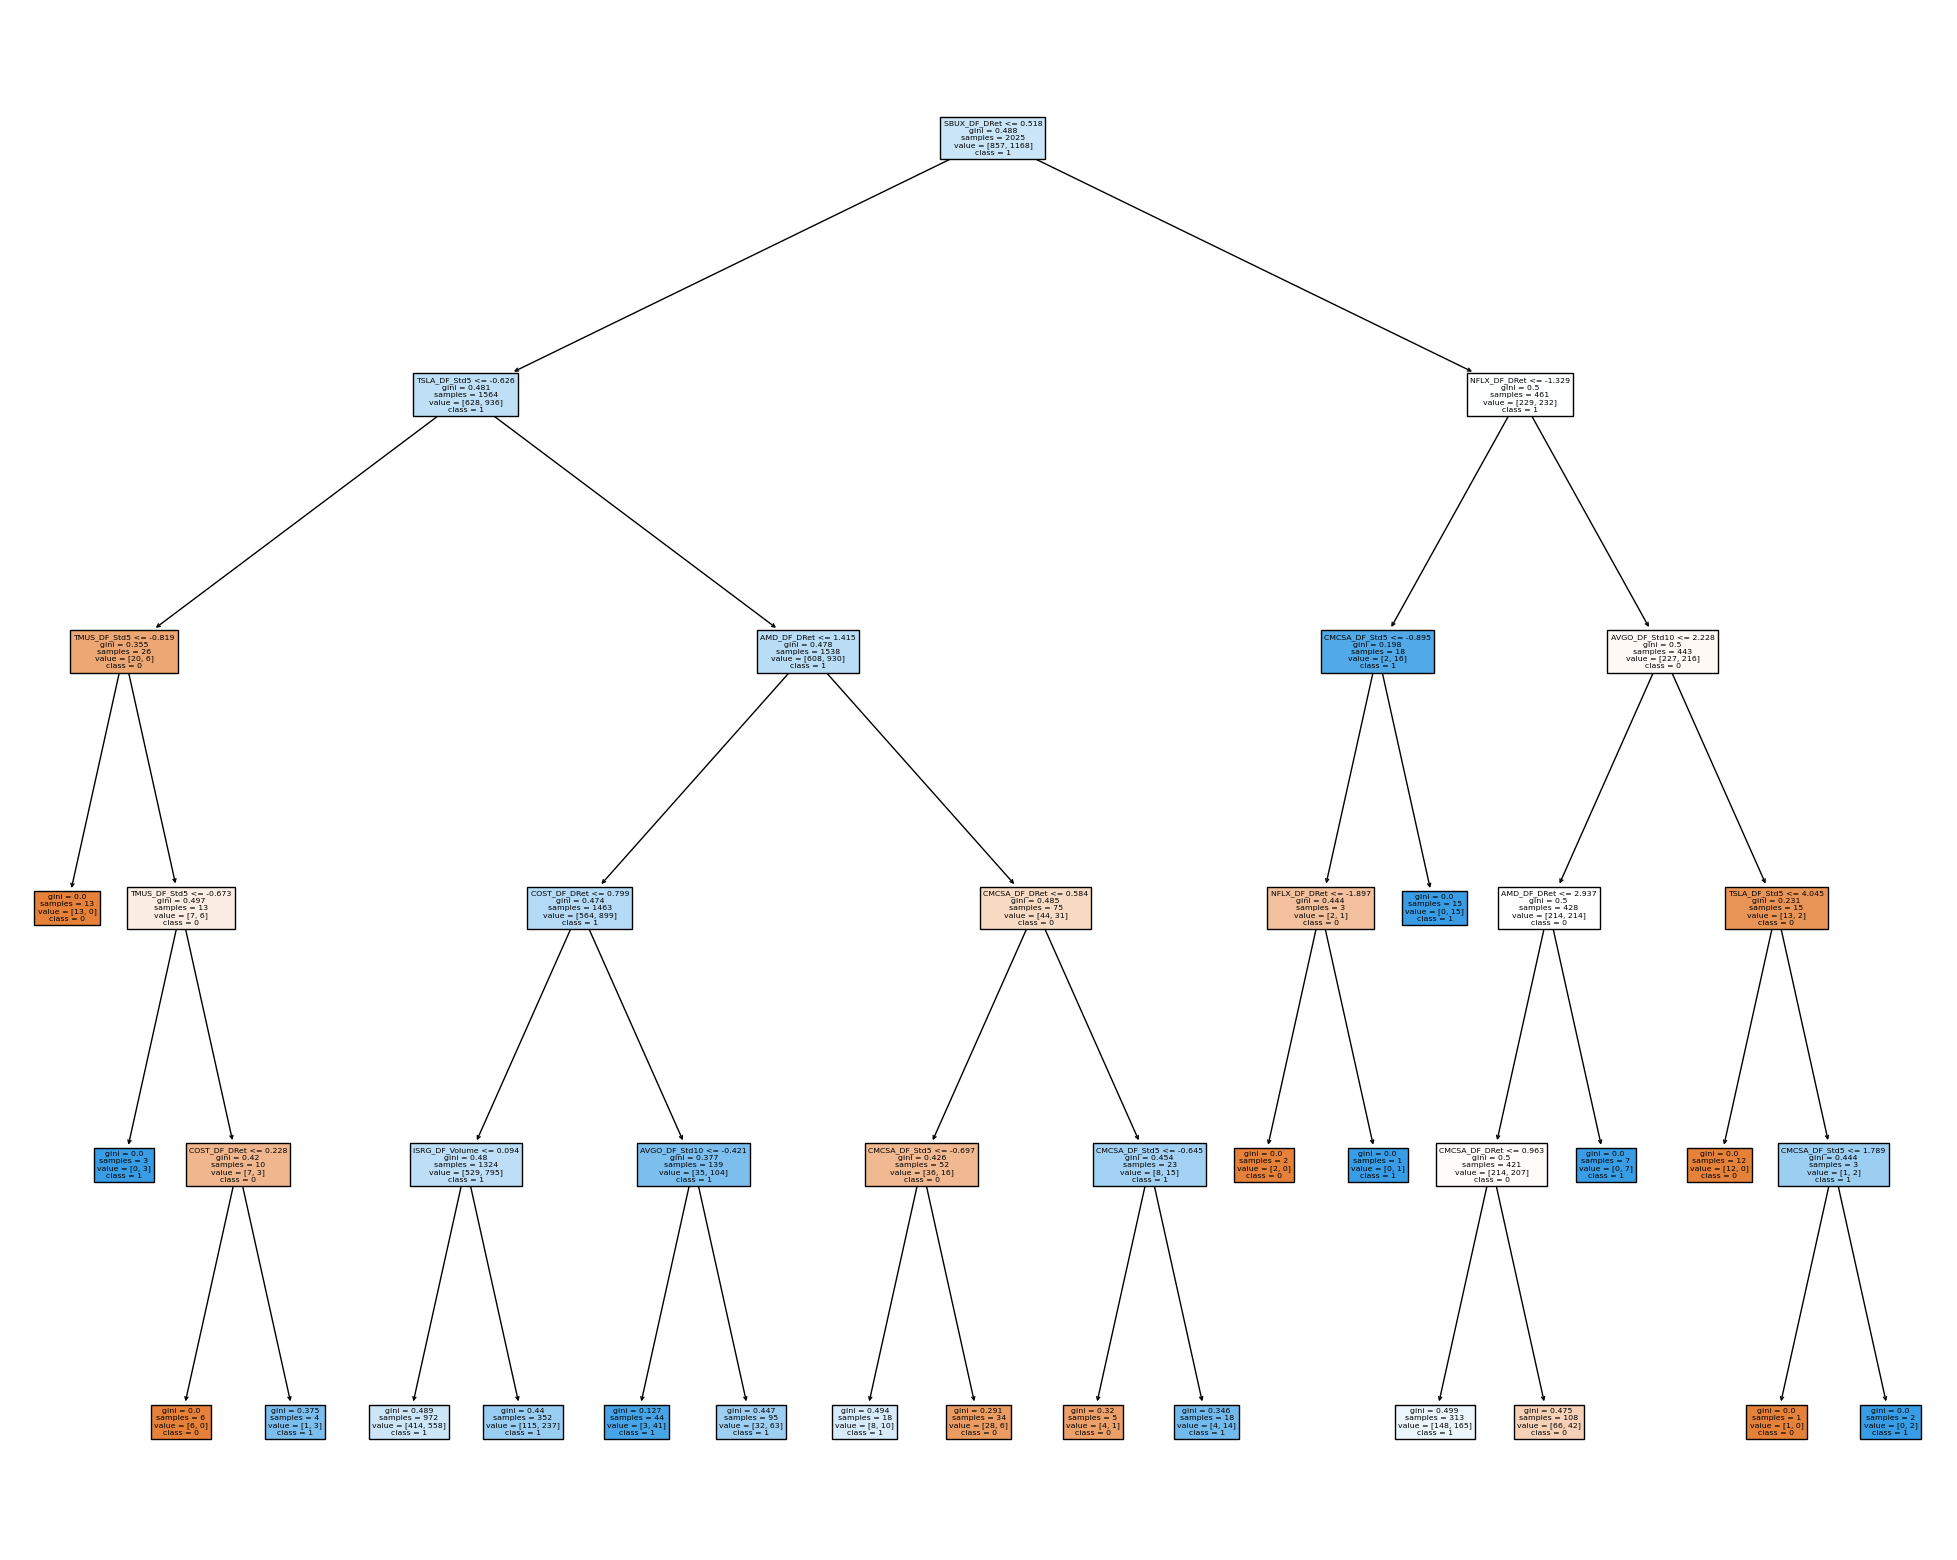

In [38]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(model, 
                   feature_names=final_feats,  
                   class_names=["0","1"],
                   filled=True)
fig.savefig("decision_tree.png")

El accuracy de pruebas del modelo es: 0.538860


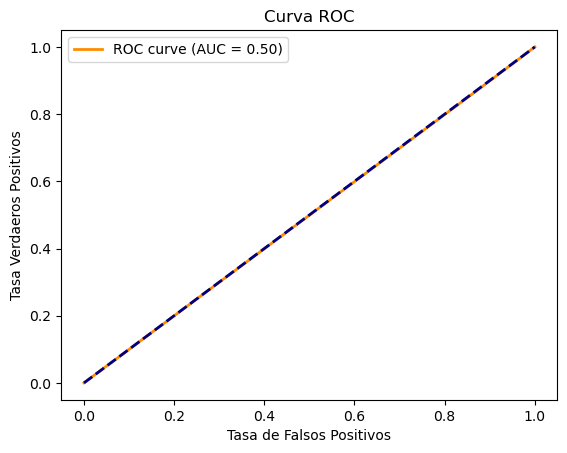

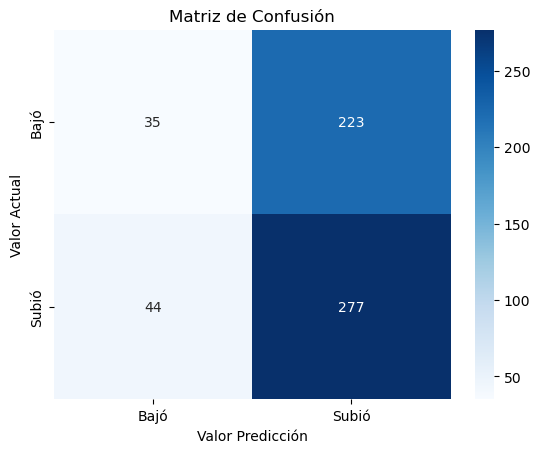

In [39]:
print(f'El accuracy de pruebas del modelo es: {acc:.6f}')

# Cálculo y grafica curva ROC y AUC
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa Verdaeros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Graficar Matriz de Confusion
cm = confusion_matrix(y_test, pred)

ax= plt.subplot()
sns.heatmap(cm, annot= True, fmt='g', ax=ax, cmap= 'Blues')

ax.set_xlabel('Valor Predicción');ax.set_ylabel('Valor Actual'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Bajó', 'Subió']); ax.yaxis.set_ticklabels(['Bajó', 'Subió']);

En la gráfica anterior podemos visualizar que donde hay mayor concentración de predicciones exitosas es precisamente en los verdaderos positivos, esto va de la mano con el resultado obtenido en la accuracy calculada

Para revisar a mayor profundidad generaremos un reporte más completo de la clasificacion así como la gráfica de la curva roc que nos permitirá ver mejor como se distribuyeron las predicciones en el espacio de la matriz de confusión.

# Modelos alternativos

Realizamos la prueba con 6 nuevos modelos

In [40]:
def get_models():
  modelos = list()
  nombres = list()

  # LR - Regresión Logística:
  modelos.append(LogisticRegression(random_state= 42))
  nombres.append('Log Reg')

  # RF - Random Forest
  modelos.append(RandomForestClassifier(random_state= 42))
  nombres.append('Rand For')
  
  # MLP - Red Neuronal Artificial / Perceptrón Lineal Multicapa:  
  modelos.append(MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000,random_state= 42))
  nombres.append('ML Perceptron')
  
  # SVM - Máquina de Vectores de Soporte:
  modelos.append(SVC(gamma='scale', probability= True, random_state= 42))
  nombres.append('Supp Vector')
  
  # GNB - Gaussian Naive Bayes:
  modelos.append(GaussianNB())
  nombres.append('Naive Bayes')

  # GB - Gradient Boosting Classifier:
  modelos.append(GradientBoostingClassifier(random_state = 42))  
  nombres.append('Grad Boost')
  
  return modelos, nombres

In [41]:
mod_b, nom_b = get_models()  # cargamos los modelos a comparar
resultados = list()
print(f'El accuracy y varianza de entrenamiento de los modelos es:')

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Entrenamiento de modelos con cross validation
    for i in range(len(mod_b)):
        start_time = time.time()

        pipeline = Pipeline(steps=[('m', mod_b[i])])
        scores = cross_val_score(pipeline, X_tt, y_tt, scoring='accuracy', cv=tscv)

        end_time = time.time()
        exec_time = (end_time - start_time)*1000
        exec_times.append(exec_time)

        resultados.append(scores)
        nombres.append(nom_b[i])
        tt_accs.append(np.mean(scores))

        # Predicciones sobre pruebas
        model = mod_b[i].fit(X_tt, y_tt)
        pred_prob = (model.predict_proba(X_test)) 
        pred_1 = ([sub_array[1] for sub_array in pred_prob]) #.values > treshold).astype(int)
        pred = [1 if value > treshold else 0 for value in pred_1]

        # Mostramos resultados
        acc = accuracy_score(y_test, pred)
        test_accs.append(acc)

        print('>> %s: %.4f (%.4f)' % (nom_b[i], np.mean(scores), np.std(scores)))

El accuracy y varianza de entrenamiento de los modelos es:
>> Log Reg: 0.5567 (0.0301)
>> Rand For: 0.5662 (0.0311)
>> ML Perceptron: 0.5228 (0.0381)
>> Supp Vector: 0.5680 (0.0361)
>> Naive Bayes: 0.5525 (0.0321)
>> Grad Boost: 0.5472 (0.0313)


In [42]:
plt.boxplot(resultados, labels=nom_b, showmeans=True)
plt.show()

# Mejores modelos alternativos

Probaremos mejorar el resultado.

In [43]:
# Inicializamos la tabla donde guardaremos
best_estims = list()
best_params = list()
best_tt_accs = list()
best_test_accs = list()

In [44]:
## Mejor Regression Logistica
modelo = mod_b[0]

dicc_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
#    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
#    'max_iter': [50, 100, 200, 500, 1000],
    'class_weight': [None, 'balanced']
             }

grid = GridSearchCV(estimator=modelo, 
                    param_grid=dicc_grid, 
                    cv=tscv, 
                    scoring='accuracy',
                    return_train_score= True,
                    n_jobs= -1)
grid.fit(X_tt, y_tt)

# Realizamos predicción sobre el otro conjunto
pred_prob= (grid.best_estimator_.predict_proba(X_test))
pred_1 = ([sub_array[1] for sub_array in pred_prob])
pred = [1 if value > treshold else 0 for value in pred_1]

acc = accuracy_score(y_test, pred)

# Guardamos datos en tablas
best_estims.append(grid.best_estimator_)
best_params.append(grid.best_params_)
best_tt_accs.append(grid.cv_results_['mean_train_score'].max())
best_test_accs.append(acc)


print('Mejor valor de exactitud obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)

Mejor valor de exactitud obtenido con la mejor combinación: 0.5768545994065282
Mejor combinación de valores encontrados de los hiperparámetros: {'C': 0.001, 'class_weight': None, 'solver': 'newton-cg'}


In [45]:
## Mejor Random Forest
modelo = mod_b[1]

dicc_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [None, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['auto', 'sqrt', 'log2', None],
    'bootstrap': [True, False]
}

grid = GridSearchCV(estimator=modelo, 
                    param_grid=dicc_grid, 
                    cv=tscv, 
                    scoring='accuracy',
                    return_train_score= True,
                    n_jobs= -1)
grid.fit(X_tt, y_tt)

# Realizamos predicción sobre el otro conjunto
pred_prob= (grid.best_estimator_.predict_proba(X_test))
pred_1 = ([sub_array[1] for sub_array in pred_prob])
pred = [1 if value > treshold else 0 for value in pred_1]

acc = accuracy_score(y_test, pred)

# Guardamos datos en tablas
best_estims.append(grid.best_estimator_)
best_params.append(grid.best_params_)
best_tt_accs.append(grid.cv_results_['mean_train_score'].max())
best_test_accs.append(acc)

print('Mejor valor de exactitud obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)

Mejor valor de exactitud obtenido con la mejor combinación: 0.5881305637982195
Mejor combinación de valores encontrados de los hiperparámetros: {'bootstrap': True, 'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500}


In [46]:
## Mejor MLP
modelo = mod_b[2]

dicc_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50, 25)],
#    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1],
#    'max_iter': [100, 200, 500],
    'batch_size': [32, 64, 128],
    'early_stopping': [True, False]
}

grid = GridSearchCV(estimator=modelo, 
                    param_grid=dicc_grid, 
                    cv=tscv, 
                    scoring='accuracy',
                    return_train_score= True,
                    n_jobs= -1)
grid.fit(X_tt, y_tt)

# Realizamos predicción sobre el otro conjunto
pred_prob= (grid.best_estimator_.predict_proba(X_test))
pred_1 = ([sub_array[1] for sub_array in pred_prob])
pred = [1 if value > treshold else 0 for value in pred_1]

acc = accuracy_score(y_test, pred)

# Guardamos datos en tablas
best_estims.append(grid.best_estimator_)
best_params.append(grid.best_params_)
best_tt_accs.append(grid.cv_results_['mean_train_score'].max())
best_test_accs.append(acc)

print('Mejor valor de exactitud obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)

Mejor valor de exactitud obtenido con la mejor combinación: 0.5774480712166172
Mejor combinación de valores encontrados de los hiperparámetros: {'alpha': 0.1, 'batch_size': 128, 'early_stopping': False, 'hidden_layer_sizes': (100,), 'solver': 'sgd'}


In [47]:
## Mejor SVM
modelo = mod_b[3]

dicc_grid = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto'] + [0.001, 0.01, 0.1, 1],
    'probability': [True]
}

grid = GridSearchCV(estimator=modelo, 
                    param_grid=dicc_grid, 
                    cv=tscv, 
                    scoring='accuracy',
                    return_train_score= True,
                    n_jobs= -1)
grid.fit(X_tt, y_tt)

# Realizamos predicción sobre el otro conjunto
pred_prob= (grid.best_estimator_.predict_proba(X_test))
pred_1 = ([sub_array[1] for sub_array in pred_prob])
pred = [1 if value > treshold else 0 for value in pred_1]

acc = accuracy_score(y_test, pred)

# Guardamos datos en tablas
best_estims.append(grid.best_estimator_)
best_params.append(grid.best_params_)
best_tt_accs.append(grid.cv_results_['mean_train_score'].max())
best_test_accs.append(acc)

print('Mejor valor de exactitud obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)

Mejor valor de exactitud obtenido con la mejor combinación: 0.5786350148367952
Mejor combinación de valores encontrados de los hiperparámetros: {'C': 10, 'gamma': 'scale', 'kernel': 'linear', 'probability': True}


In [48]:
# Mejor Naive Bayes
modelo = mod_b[4]

dicc_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]
}

grid = GridSearchCV(estimator=modelo, 
                    param_grid=dicc_grid, 
                    cv=tscv, 
                    scoring='accuracy',
                    return_train_score= True,
                    n_jobs= -1)
grid.fit(X_tt, y_tt)

# Realizamos predicción sobre el otro conjunto
pred_prob= (grid.best_estimator_.predict_proba(X_test))
pred_1 = ([sub_array[1] for sub_array in pred_prob])
pred = [1 if value > treshold else 0 for value in pred_1]

acc = accuracy_score(y_test, pred)

# Guardamos datos en tablas
best_estims.append(grid.best_estimator_)
best_params.append(grid.best_params_)
best_tt_accs.append(grid.cv_results_['mean_train_score'].max())
best_test_accs.append(acc)

print('Mejor valor de exactitud obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)

Mejor valor de exactitud obtenido con la mejor combinación: 0.5525222551928783
Mejor combinación de valores encontrados de los hiperparámetros: {'var_smoothing': 1e-09}


In [49]:
#Mejor Grad Boost
modelo = mod_b[5]

dicc_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(estimator=modelo, 
                    param_grid=dicc_grid, 
                    cv=tscv, 
                    scoring='accuracy',
                    return_train_score= True,
                    n_jobs= -1)
grid.fit(X_tt, y_tt)

# Realizamos predicción sobre el otro conjunto
pred_prob= (grid.best_estimator_.predict_proba(X_test))
pred_1 = ([sub_array[1] for sub_array in pred_prob])
pred = [1 if value > treshold else 0 for value in pred_1]

acc = accuracy_score(y_test, pred)

# Guardamos datos en tablas
best_estims.append(grid.best_estimator_)
best_params.append(grid.best_params_)
best_tt_accs.append(grid.cv_results_['mean_train_score'].max())
best_test_accs.append(acc)

print('Mejor valor de exactitud obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)

Mejor valor de exactitud obtenido con la mejor combinación: 0.5845697329376854
Mejor combinación de valores encontrados de los hiperparámetros: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 50}


# Redes Neuronales

Probamos con un modelo de red neuronal para regresión. Este modelo utiliza una arquitectura básica de red neuronal feedforward con capas densas, activaciones ReLU y técnicas de regularización Dropout.

In [50]:
start_time = time.time()
      
# Definir el modelo
rnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_tt.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Capa de salida
])

# Compilar el modelo
rnn_model.compile(optimizer=Adam(learning_rate= 0.0005), loss='BinaryCrossentropy', metrics = ["accuracy"])

# Entrenar el modelo
history = rnn_model.fit(X_tt, y_tt, epochs=50, batch_size=32, validation_data=(X_test, y_test))

# Recuperar el tiempo de entrenamiento
end_time = time.time()
exec_time = (end_time - start_time)*1000
exec_times.append(exec_time)

# Guardar información del modelo
nombres.append('NN')
tt_accs.append(max(history.history['accuracy']))
test_accs.append(max(history.history['val_accuracy']))

# Predicciones sobre pruebas
rnn_pred = (rnn_model.predict(X_test) > treshold).astype(int)
acc = accuracy_score(y_test, rnn_pred)


Epoch 1/50
64/64 [==============================] - 2s 10ms/step - loss: 0.7124 - accuracy: 0.5491 - val_loss: 0.6927 - val_accuracy: 0.5320
Epoch 2/50
64/64 [==============================] - 0s 7ms/step - loss: 0.7010 - accuracy: 0.5393 - val_loss: 0.6920 - val_accuracy: 0.5492
Epoch 3/50
64/64 [==============================] - 0s 7ms/step - loss: 0.6959 - accuracy: 0.5669 - val_loss: 0.6961 - val_accuracy: 0.5544
Epoch 4/50
64/64 [==============================] - 0s 7ms/step - loss: 0.6920 - accuracy: 0.5723 - val_loss: 0.6945 - val_accuracy: 0.5561
Epoch 5/50
64/64 [==============================] - 0s 7ms/step - loss: 0.6863 - accuracy: 0.5640 - val_loss: 0.6935 - val_accuracy: 0.5527
Epoch 6/50
64/64 [==============================] - 0s 7ms/step - loss: 0.6868 - accuracy: 0.5689 - val_loss: 0.6904 - val_accuracy: 0.5509
Epoch 7/50
64/64 [==============================] - 0s 7ms/step - loss: 0.6834 - accuracy: 0.5664 - val_loss: 0.6890 - val_accuracy: 0.5527
Epoch 8/50
64/64 [=

El accuracy de pruebas del modelo es: 0.559585


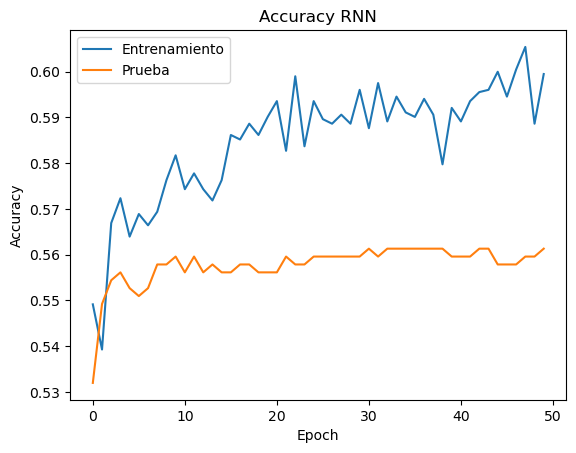

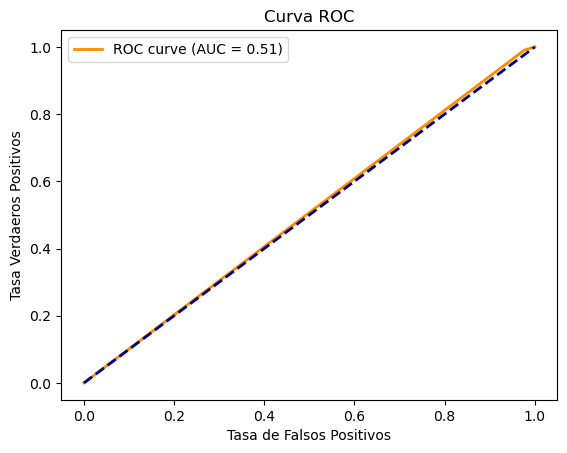

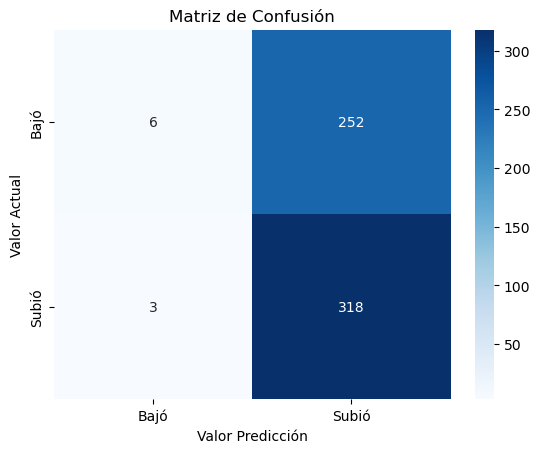

In [51]:
print(f'El accuracy de pruebas del modelo es: {acc:.6f}')

# Graficar el accuracy por Epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy RNN')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()

# Cálculo y grafica curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, rnn_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa Verdaeros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Graficar confusion
cm = confusion_matrix(y_test, rnn_pred)

ax= plt.subplot()
sns.heatmap(cm, annot= True, fmt='g', ax=ax, cmap= 'Blues')

ax.set_xlabel('Valor Predicción');ax.set_ylabel('Valor Actual'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Bajó', 'Subió']); ax.yaxis.set_ticklabels(['Bajó', 'Subió']);

A continuación exploraremos el uso de una LSTM

In [52]:
# Definimos el largo de las sequencias y "memoria" que deseamos tener
sequence_length = 20

# Generamos una función que genera los arreglos con las secuencias necesarias para la LSTM
def create_sequences(X, y, sequence_length):
    sequences, labels = [], []
    for i in range(len(X) - sequence_length):
        seq = X[i:i+sequence_length]
        label = y[i+sequence_length-1:i+sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels).ravel()

# Creamos las X con sus respectivas secuencias
X_tt_lstm, y_tt_lstm = create_sequences(X_tt, y_tt, sequence_length)
X_test_lstm, y_test_lstm = create_sequences(X_test, y_test, sequence_length)

# Ajustamos y_test para eliminar los primeros n registros, resultado de la sequencia de memoria
y_test_lstm = y_test[sequence_length:]

X_tt_lstm.shape

(2005, 20, 15)

In [53]:
start_time = time.time()

# Definimos nuestra LSTM
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_tt_lstm.shape[1], X_tt_lstm.shape[2])),
    Dropout(0.4),
    LSTM(64, return_sequences=True),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.4),
    Dense(1, activation= 'sigmoid')  # Capa de salida 
])

lstm_model.compile(optimizer= Adam(learning_rate= 0.0005), 
              loss='BinaryCrossentropy',
              metrics = ["accuracy"])

# Entrenar el modelo
history = lstm_model.fit(X_tt_lstm, y_tt_lstm, epochs= 50, batch_size= 32, validation_data=(X_test_lstm, y_test_lstm))

# Recuperar el tiempo de entrenamiento
end_time = time.time()
exec_time = (end_time - start_time)*1000
exec_times.append(exec_time)
               
# Guardar información del modelo
nombres.append('LSTM')
tt_accs.append(max(history.history['accuracy']))
test_accs.append(max(history.history['val_accuracy']))

# Predicciones sobre pruebas
lstm_pred = (lstm_model.predict(X_test_lstm) > treshold).astype(int)
acc = accuracy_score(y_test_lstm, lstm_pred)

Epoch 1/50
63/63 [==============================] - 7s 36ms/step - loss: 0.6884 - accuracy: 0.5551 - val_loss: 0.6901 - val_accuracy: 0.5385
Epoch 2/50
63/63 [==============================] - 1s 15ms/step - loss: 0.6820 - accuracy: 0.5716 - val_loss: 0.6905 - val_accuracy: 0.5528
Epoch 3/50
63/63 [==============================] - 1s 15ms/step - loss: 0.6819 - accuracy: 0.5721 - val_loss: 0.6921 - val_accuracy: 0.5528
Epoch 4/50
63/63 [==============================] - 1s 16ms/step - loss: 0.6800 - accuracy: 0.5756 - val_loss: 0.6917 - val_accuracy: 0.5528
Epoch 5/50
63/63 [==============================] - 1s 15ms/step - loss: 0.6779 - accuracy: 0.5731 - val_loss: 0.6905 - val_accuracy: 0.5438
Epoch 6/50
63/63 [==============================] - 1s 16ms/step - loss: 0.6797 - accuracy: 0.5771 - val_loss: 0.6935 - val_accuracy: 0.5528
Epoch 7/50
63/63 [==============================] - 1s 16ms/step - loss: 0.6782 - accuracy: 0.5671 - val_loss: 0.6972 - val_accuracy: 0.5528
Epoch 8/50
63

El accuracy de pruebas del modelo es: 0.508050


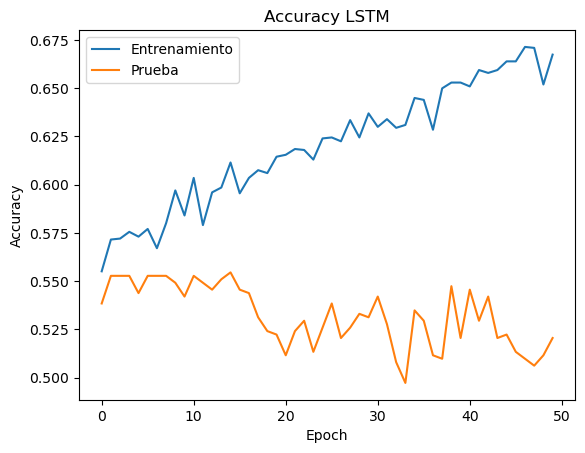

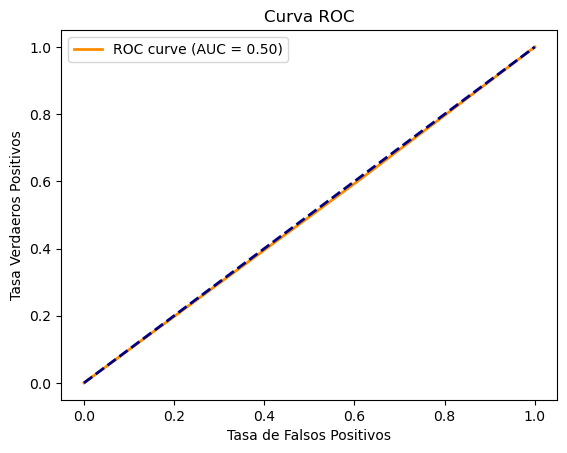

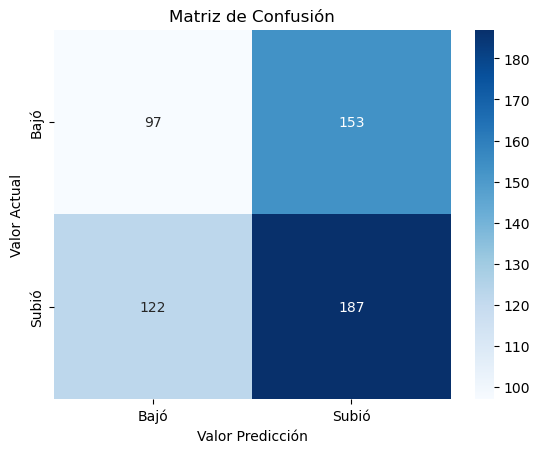

In [54]:
print(f'El accuracy de pruebas del modelo es: {acc:.6f}')

# Graficar el accuracy por Epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy LSTM')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Entrenamiento', 'Prueba'], loc='upper left')
plt.show()


# Cálculo y grafica curva ROC y AUC
fpr, tpr, threshold = roc_curve(y_test_lstm, lstm_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa Verdaeros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Graficar Matriz de Confusion
cm = confusion_matrix(y_test_lstm, lstm_pred)

ax= plt.subplot()
sns.heatmap(cm, annot= True, fmt='g', ax=ax, cmap= 'Blues')

ax.set_xlabel('Valor Predicción');ax.set_ylabel('Valor Actual'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Bajó', 'Subió']); ax.yaxis.set_ticklabels(['Bajó', 'Subió']);

# Ensemble model

A continuación realizaremos un par de modelos ensemble homogeneos, los cuales son Random Forest y Adaboost:

In [55]:
# Inicializaremos listas que usaremos para comparar los modelos
nomb_c = list()
mod_c = list()
tt_accs_c = list()
test_accs_c = list()
exec_times_c = list()

# Añadimos nuestro mejor modelo de NN como base
nomb_c.append(nombres[7])
tt_accs_c.append(tt_accs[7])
test_accs_c.append(test_accs[7])
exec_times_c.append(exec_times[7])

In [56]:
# Generamos el Ensemble Random Forest
# Inicializamos el tiempo de entrenamiento
start_time = time.time()

# Creamos el modelo y entrenamos
model = best_estims[1]

# Probamos el modelo para diferentes números de features
scores = cross_val_score(model,
                           X_tt,
                           y_tt,
                           cv=tscv,
                           scoring= 'accuracy')

# Detenemos el tiempo de entrenamiento
end_time = time.time()
exec_time = (end_time - start_time)*1000


# Predicciones sobre pruebas
model = best_estims[1].fit(X_tt, y_tt)
pred_prob= (best_estims[1].predict_proba(X_test))
pred_1 = ([sub_array[1] for sub_array in pred_prob])
pred = [1 if value > treshold else 0 for value in pred_1]

# Mostramos resultados
acc = accuracy_score(y_test, pred)

# Almacenamos información
nomb_c.append('Rand For')
tt_accs_c.append(np.mean(scores))
test_accs_c.append(acc)
exec_times_c.append(exec_time)

print(f'El accuracy de entrenamiento del modelo es: {scores.mean():.6f}')

El accuracy de entrenamiento del modelo es: 0.588131


El accuracy de pruebas del modelo es: 0.533679


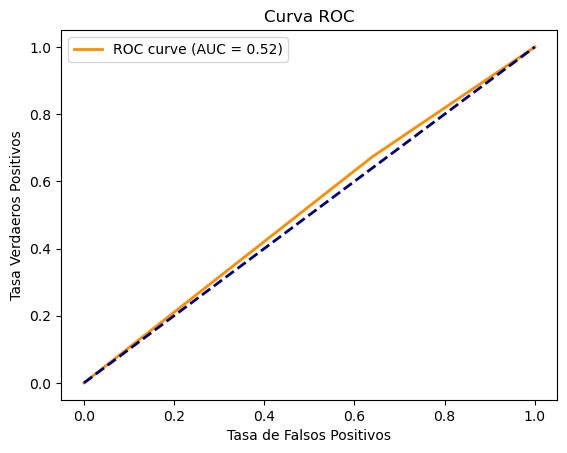

In [57]:
print(f'El accuracy de pruebas del modelo es: {acc:.6f}')

# Cálculo y grafica curva ROC y AUC
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa Verdaeros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Graficar Matriz de Confusion
cm = confusion_matrix(y_test, pred)

ax= plt.subplot()
sns.heatmap(cm, annot= True, fmt='g', ax=ax, cmap= 'Blues')

ax.set_xlabel('Valor Predicción');ax.set_ylabel('Valor Actual'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Bajó', 'Subió']); ax.yaxis.set_ticklabels(['Bajó', 'Subió']);

In [58]:
# Generamos el ensemble Adaboost
# Inicializamos el tiempo de entrenamiento
start_time = time.time()

# Creamos el modelo y entrenamos
base_classifier = DecisionTreeClassifier(max_depth=1)

model = AdaBoostClassifier(
    base_classifier,
    n_estimators=200,
    learning_rate=1.0
)

# Probamos el modelo para diferentes números de features
scores = cross_val_score(model,
                           X_tt,
                           y_tt,
                           cv=tscv,
                           scoring= 'accuracy')

# Detenemos el tiempo de entrenamiento
end_time = time.time()
exec_time = (end_time - start_time)*1000


# Predicciones sobre pruebas
model = model.fit(X_tt, y_tt)
pred_prob= (model.predict_proba(X_test))
pred_1 = ([sub_array[1] for sub_array in pred_prob])
pred = [1 if value > treshold else 0 for value in pred_1]

# Mostramos resultados
acc = accuracy_score(y_test, pred)

# Almacenamos información
nomb_c.append('Adaboost (DT)')
tt_accs_c.append(np.mean(scores))
test_accs_c.append(acc)
exec_times_c.append(exec_time)

print(f'El accuracy de entrenamiento del modelo es: {scores.mean():.6f}')

El accuracy de entrenamiento del modelo es: 0.528190


In [59]:
print(f'El accuracy de pruebas del modelo es: {acc:.6f}')

# Cálculo y grafica curva ROC y AUC
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa Verdaeros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Graficar Matriz de Confusion
cm = confusion_matrix(y_test, pred)

ax= plt.subplot()
sns.heatmap(cm, annot= True, fmt='g', ax=ax, cmap= 'Blues')

ax.set_xlabel('Valor Predicción');ax.set_ylabel('Valor Actual'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Bajó', 'Subió']); ax.yaxis.set_ticklabels(['Bajó', 'Subió']);

El accuracy de pruebas del modelo es: 0.449050


A continuación realizaremos un par de modelos ensemble heterogeneos:

In [60]:
# Primero utilizaremos un simple voto entre los mejores modelos alternativos + NN

start_time = time.time()

# Generamos dataframe con las predicciones de entrenamiento clase de los mejores modelos
ens_df= pd.DataFrame(columns=[nom_b + ['NN']])
for i in range(len(nom_b)):   
    model = best_estims[i]
    pred = model.predict(X_tt)
    ens_df[nom_b[i]] = pred.ravel()
ens_df['NN'] = (rnn_model.predict(X_tt) > treshold).ravel().astype(int)   
ens_df["Vote"] = ((ens_df.cumsum(axis=1).iloc[:, -1]) >= 4).astype(int)

# Calcular accuracy de entrenamiento
acc_tt = accuracy_score(y_tt, ens_df['Vote'])

# Finaliza medición de tiempo
end_time = time.time()
exec_time = (end_time - start_time)*1000

# Generamos dataframe con las predicciones de prueba clase de los mejores modelos
ens_df= pd.DataFrame(columns=[nom_b + ['NN']])
for i in range(len(nom_b)):   
    model = best_estims[i]
    pred = model.predict(X_test)
    ens_df[nom_b[i]] = pred.ravel()
ens_df['NN'] = (rnn_model.predict(X_test) > treshold).ravel().astype(int)   
ens_df["Vote"] = ((ens_df.cumsum(axis=1).iloc[:, -1]) >= 4).astype(int)

# Calcular accuracy de pruebas
acc_test = accuracy_score(y_test, ens_df['Vote'])


# Almacenamos informacion
nomb_c.append('Votación')
tt_accs_c.append(acc_tt)
test_accs_c.append(acc_test)
exec_times_c.append(exec_time)

print(f'El accuracy de entrenamiento del modelo es: {acc_tt:.6f}')
print(f'El accuracy de pruebas del modelo es: {acc_test:.6f}')

19/19 [==============================] - 0s 2ms/step
El accuracy de entrenamiento del modelo es: 0.613827
El accuracy de pruebas del modelo es: 0.556131


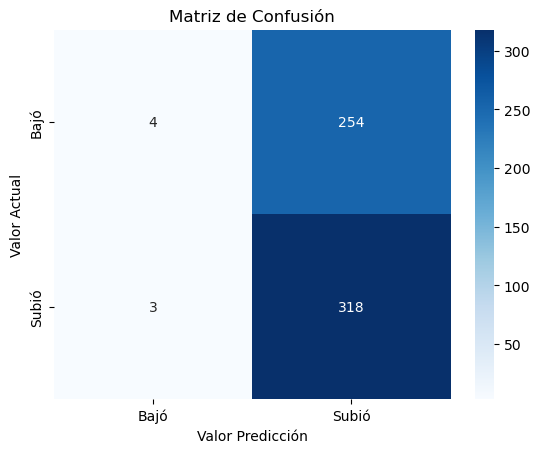

In [61]:
# Mostramos resultados

# Cálculo y grafica curva ROC y AUC
fpr, tpr, threshold = roc_curve(y_test, ens_df['Vote'])
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa Verdaeros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

cm = confusion_matrix(y_test, ens_df['Vote'])

ax= plt.subplot()
sns.heatmap(cm, annot= True, fmt='g', ax=ax, cmap= 'Blues')

ax.set_xlabel('Valor Predicción');ax.set_ylabel('Valor Actual'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Bajó', 'Subió']); ax.yaxis.set_ticklabels(['Bajó', 'Subió']);

In [62]:
# Segundo utilizaremos una regresión logística sobre las predicciones de los mejores modelos

start_time = time.time()

# Generamos dataframe con las predicciones de entrenamiento clase de los mejores modelos
ens_df= pd.DataFrame(columns=[nom_b + ['NN']])
for i in range(len(nom_b)):   
    model = best_estims[i]
    pred_prob= (model.predict_proba(X_tt))
    pred_1 = ([sub_array[1] for sub_array in pred_prob])
#    pred = [1 if value > treshold else 0 for value in pred_1]
    ens_df[nom_b[i]] = pred_1
ens_df['NN'] = (rnn_model.predict(X_tt))


# Entrenamos modelo sobre los resultados de los anteriores
ens_mod = LogisticRegression(random_state= 42, n_jobs= -1)
ens_mod = ens_mod.fit(ens_df, y_tt)

# Calcular accuracy de entrenamiento
pred = ens_mod.predict(ens_df)
acc_tt = accuracy_score(y_tt, pred)

# Finaliza medición de tiempo
end_time = time.time()
exec_time = (end_time - start_time)*1000


# Generamos dataframe con las predicciones de pruebas clase de los mejores modelos
ens_df= pd.DataFrame(columns=[nom_b + ['NN']])
for i in range(len(nom_b)):   
    model = best_estims[i]
    pred_prob= (model.predict_proba(X_test))
    pred_1 = ([sub_array[1] for sub_array in pred_prob])
#    pred = [1 if value > treshold else 0 for value in pred_1]
    ens_df[nom_b[i]] = pred_1
ens_df['NN'] = (rnn_model.predict(X_test))

# Calcular accuracy de pruebas
pred = ens_mod.predict(ens_df)
acc_test = accuracy_score(y_test, pred)

# Almacenamos informacion
nomb_c.append('Ens Log Reg')
tt_accs_c.append(acc_tt)
test_accs_c.append(acc_test)
exec_times_c.append(exec_time)

print(f'El accuracy de entrenamiento del modelo es: {acc_tt:.6f}')
print(f'El accuracy de pruebas del modelo es: {acc_test:.6f}')

19/19 [==============================] - 0s 2ms/step
El accuracy de entrenamiento del modelo es: 1.000000
El accuracy de pruebas del modelo es: 0.533679


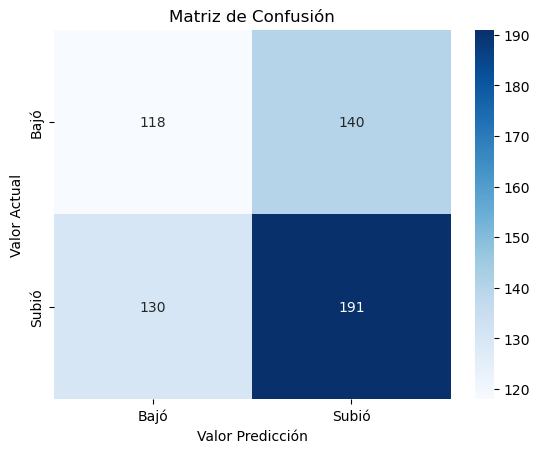

In [63]:
# Mostramos resultados

# Cálculo y grafica curva ROC y AUC
fpr, tpr, threshold = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa Verdaeros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

cm = confusion_matrix(y_test, pred)

ax= plt.subplot()
sns.heatmap(cm, annot= True, fmt='g', ax=ax, cmap= 'Blues')

ax.set_xlabel('Valor Predicción');ax.set_ylabel('Valor Actual'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Bajó', 'Subió']); ax.yaxis.set_ticklabels(['Bajó', 'Subió']);

# Reporte

In [ ]:
# Formateo de números para visualización
tt_accs = [round(x*100, 4) for x in tt_accs]
test_accs = [round(x*100, 4) for x in test_accs]
exec_times = [round(x, 4) for x in exec_times]

best_tt_accs = [round(x*100, 4) for x in best_tt_accs]
best_test_accs = [round(x*100, 4) for x in best_test_accs]

tt_accs_c= [round(x*100, 4) for x in tt_accs_c]
test_accs_c= [round(x*100, 4) for x in test_accs_c]
exec_times_c=  [round(x*100, 4) for x in exec_times_c]

In [65]:
# Generación de tabla modelos base
pt = PrettyTable()
pt_cols = ["Modelo Base", "Acc. Entren(%)", "Acc. Prueba(%)", "Tiempo Entren(ms)"]

pt.add_column(pt_cols[0], nombres)
pt.add_column(pt_cols[1], tt_accs)
pt.add_column(pt_cols[2], test_accs)
pt.add_column(pt_cols[3], exec_times)

# Generación de tabla mejores modelos
pt2 = PrettyTable()
pt2_cols = ["Mejor Modelo Base", "Acc. Entren(%)", "Acc. Prueba(%)"]

pt2.add_column(pt2_cols[0], nom_b)
#pt2.add_column(pt2_cols[1], best_params)
pt2.add_column(pt2_cols[1], best_tt_accs)
pt2.add_column(pt2_cols[2], best_test_accs)

# Generación de tabla modelos ensemble
pt3 = PrettyTable()
pt3_cols = ["Modelo Ensemble", "Acc. Entren(%)", "Acc. Prueba(%)", "Tiempo Entren(ms)"]

pt3.add_column(pt2_cols[0], nomb_c)
#pt2.add_column(pt2_cols[1], best_params)
pt3.add_column(pt2_cols[1], tt_accs_c)
pt3.add_column(pt2_cols[2], test_accs_c)
pt3.add_column(pt_cols[3], exec_times_c)


In [66]:
%%capture cap

# Capturamos la celda,y generamos un resumen que muestre en pantalla y se guarde en archivo
timestamp = datetime.now()
timestamp = timestamp.strftime("%Y-%m-%d %H:%M:%S")

print(f'Resumen de ejecución:     {timestamp}\n')
print(f'Núm. de empresas:         {top_n}')
print(f'Fecha inicial de data:    {start_date}')
print(f'Fecha final de data:      {end_date}\n')

print('Distribución de las particiones:')
print(f'Entrenamiento:  {q_tt*100:.0f}%')
print(f'Pruebas:        {q_test*100:.0f}%')
print(f'Validación:     {q_val*100:.0f}%\n')

print(f'Preprocesado:')
print(f'Estandarización:     {std_scaler}')
print(f'Normalización:       {nor_scaler}')
print(f'Número de variables: {len(final_feats)}')
print(f'Treshold Predicción: {treshold}\n')

print(f'Modelos base:')
print(pt)
print('')

print(f'Modelos optimizados:')
print(pt2)
print('')

print(f'Modelos ensemble:')
print(pt3)
print('')

print(f'***********  FIN DE EJECUCION  ***********')


In [67]:
print(cap.show())

with open('output.txt', 'a') as file:
    file.write(cap.stdout + "\n")

Resumen de ejecución:     2024-03-03 12:17:30

Núm. de empresas:         30
Fecha inicial de data:    2012-06-01
Fecha final de data:      2023-12-31

Distribución de las particiones:
Entrenamiento:  70%
Pruebas:        20%
Validación:     10%

Preprocesado:
Estandarización:     StandardScaler()
Normalización:       NA
Número de variables: 15
Treshold Predicción: 0.51

Modelos base:
+---------------------+----------------+----------------+-------------------+
|     Modelo Base     | Acc. Entren(%) | Acc. Prueba(%) | Tiempo Entren(ms) |
+---------------------+----------------+----------------+-------------------+
| Dec Tree (Baseline) |    53.4125     |     53.886     |       67.498      |
|       Log Reg       |    55.6677     |    55.2677     |      54.5001      |
|       Rand For      |    56.6172     |    52.8497     |       2783.0      |
|    ML Perceptron    |    52.2849     |    51.9862     |     22543.4966    |
|     Supp Vector     |    56.7953     |    55.4404     |     2488.9